# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

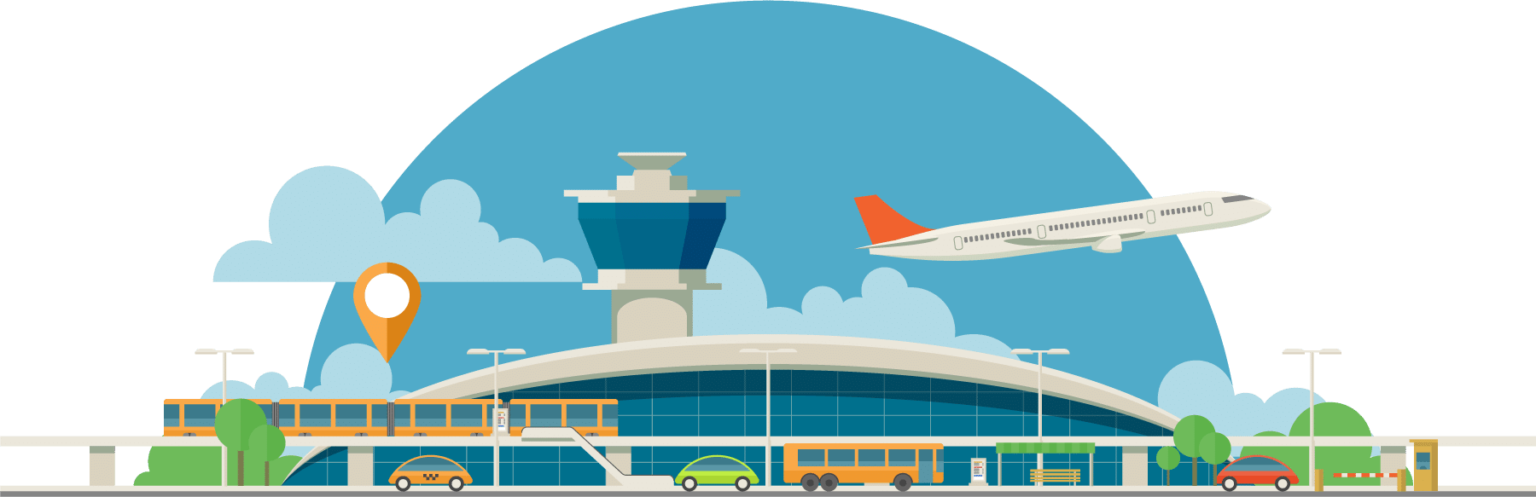

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [1]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=e78872deb7f86b984c60bcc7fb6ccaa34a8972ab73e9bf5e59076d4989969834
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2024-01-01 14:07:42--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2024-01-01 14:07:43 (1016 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно.

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

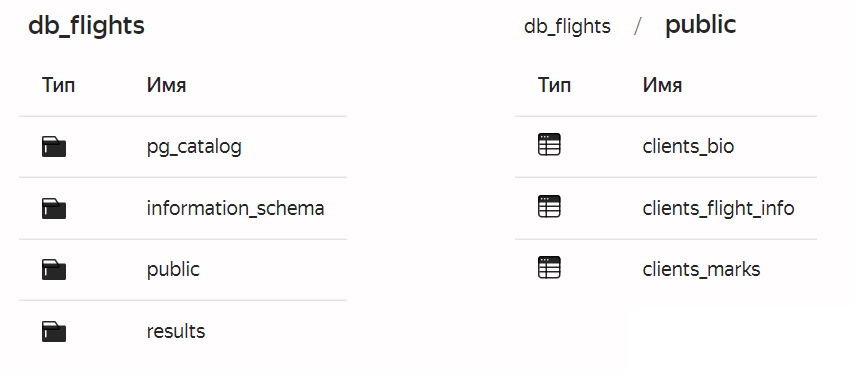

In [4]:
# your code below

conn = psycopg2.connect("""host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432 sslmode=verify-full
dbname=db_flights user=mlhs_student
password=mlhs_student
target_session_attrs=read-write""")

In [5]:
cur = conn.cursor()

In [6]:
cur.execute("""
SELECT * FROM clients_bio bio
INNER JOIN clients_flight_info info ON
bio.id = info.id
INNER JOIN clients_marks marks ON
bio.id = marks.id""")
data = cur.fetchall()

In [7]:
colnames = [desc[0] for desc in cur.description]

In [8]:
df = pd.DataFrame(data=data, columns = colnames)
df = df.loc[:,~df.columns.duplicated()].set_index('id').copy()

In [9]:
df

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   
129868    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   

       Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                           
7               1963.0                        0.0                      0.0   
13               453.0                       16.0                     30.0   
18               821.0                        0.0                      0.0   
31               212.0                        0.0                      0.0   
39                67.0                        0.0                      0.0   
...                ...                        ...                      ...   
129838           308.0                       32.0                     24.0   
129839           337.0                        0.0                      0.0   
129846           447.0                        0.0                      0.0   
129868           447.0                        0.0                      0.0   
129876           447.0                        2.0                      3.0   

       Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                              ...   
7                        3.0                               3.0  ...   
13                       2.0                               2.0  ...   
18                       2.0                               5.0  ...   
31                       2.0                               2.0  ...   
39                       3.0                               3.0  ...   
...                      ...                               ...  ...   
129838                   3.0                               5.0  ...   
129839                   2.0                               4.0  ...   
129846                   2.0                               5.0  ...   
129868                   3.0                               4.0  ...   
129876                   4.0                               4.0  ...   

       Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                            
7                  4.0          5.0                    5.0              5.0   
13                 2.0          5.0                    5.0              2.0   
18                 1.0          5.0                    5.0              5.0   
31                 2.0          2.0                    2.0              4.0   
39                 5.0          4.0                    4.0              4.0   
...                ...          ...                    ...              ...   
129838             5.0          5.0                    3.0              3.0   
129839             2.0          3.0                    3.0              4.0   
129846             2.0          5.0                    5.0              4.0   
129868             3.0          4.0                    4.0              2.0   
129876             4.0          1.0                    4.0              5.0   

       Leg room service Baggage handling Checkin service Inflight service  \
id                                                   

In [10]:
cur.close()
conn.close()

In [11]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [12]:
df = df.replace('nan', pd.NA)

In [13]:
df.isna().sum()

gender                                 0
age                                  315
Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

In [14]:
# your code below

df = df.apply(pd.to_numeric, errors='ignore')

In [15]:
df

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   
129868    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   
129868              3.0           4.0                     4.0   
129876              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

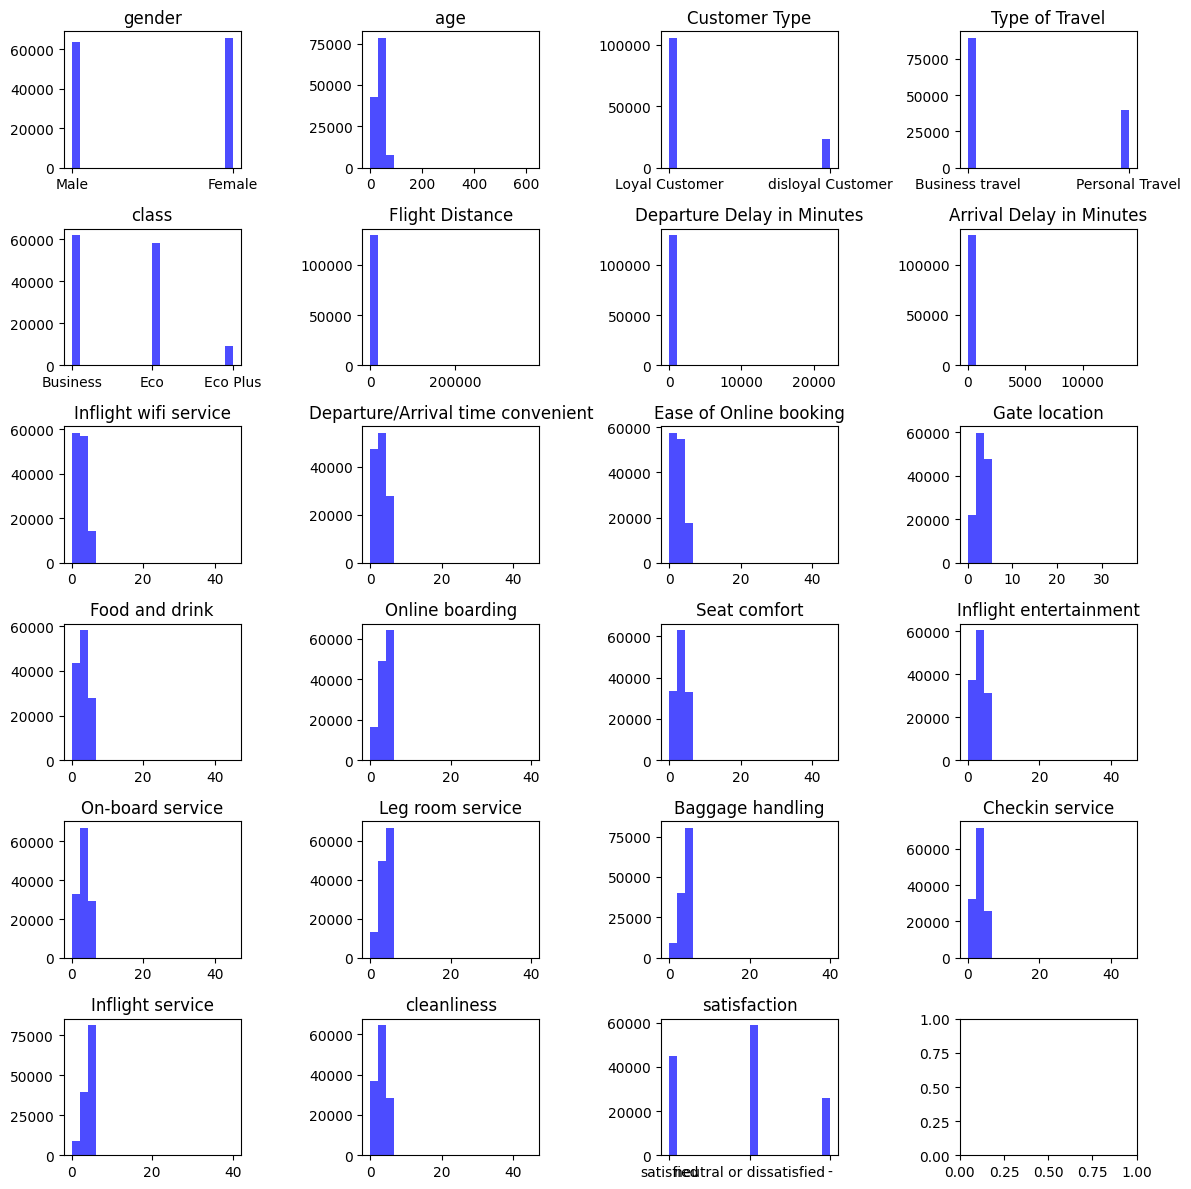

In [16]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i in range(len(df.columns)):
    axes[i].hist(df[df.columns[i]].dropna(), bins=20, color='blue', alpha=0.7)
    axes[i].set_title(df.columns[i])

plt.tight_layout()

plt.show()

(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<Axes: >

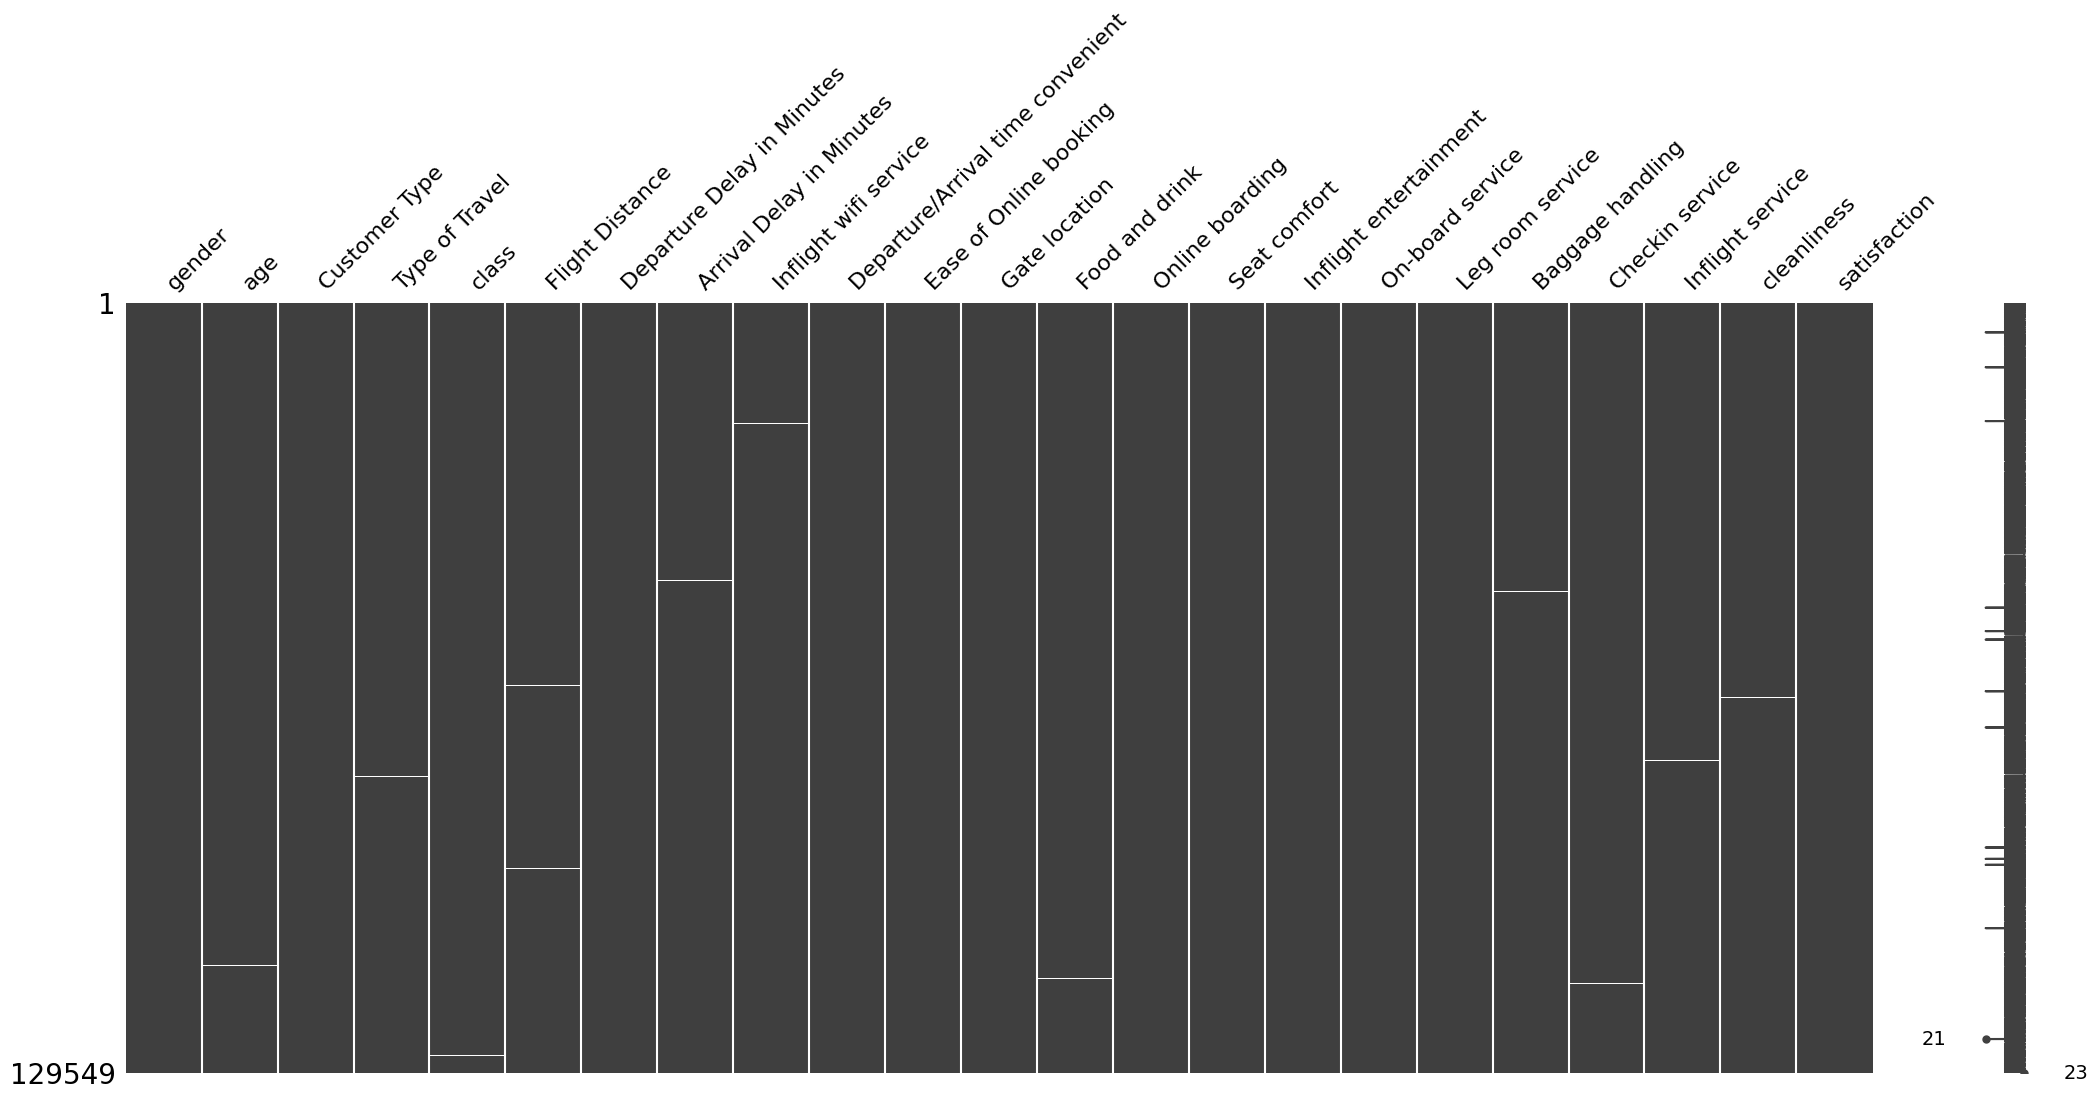

In [17]:
# your code below

missingno.matrix(df)

FixedFormatter should only be used together with FixedLocator


<Axes: >

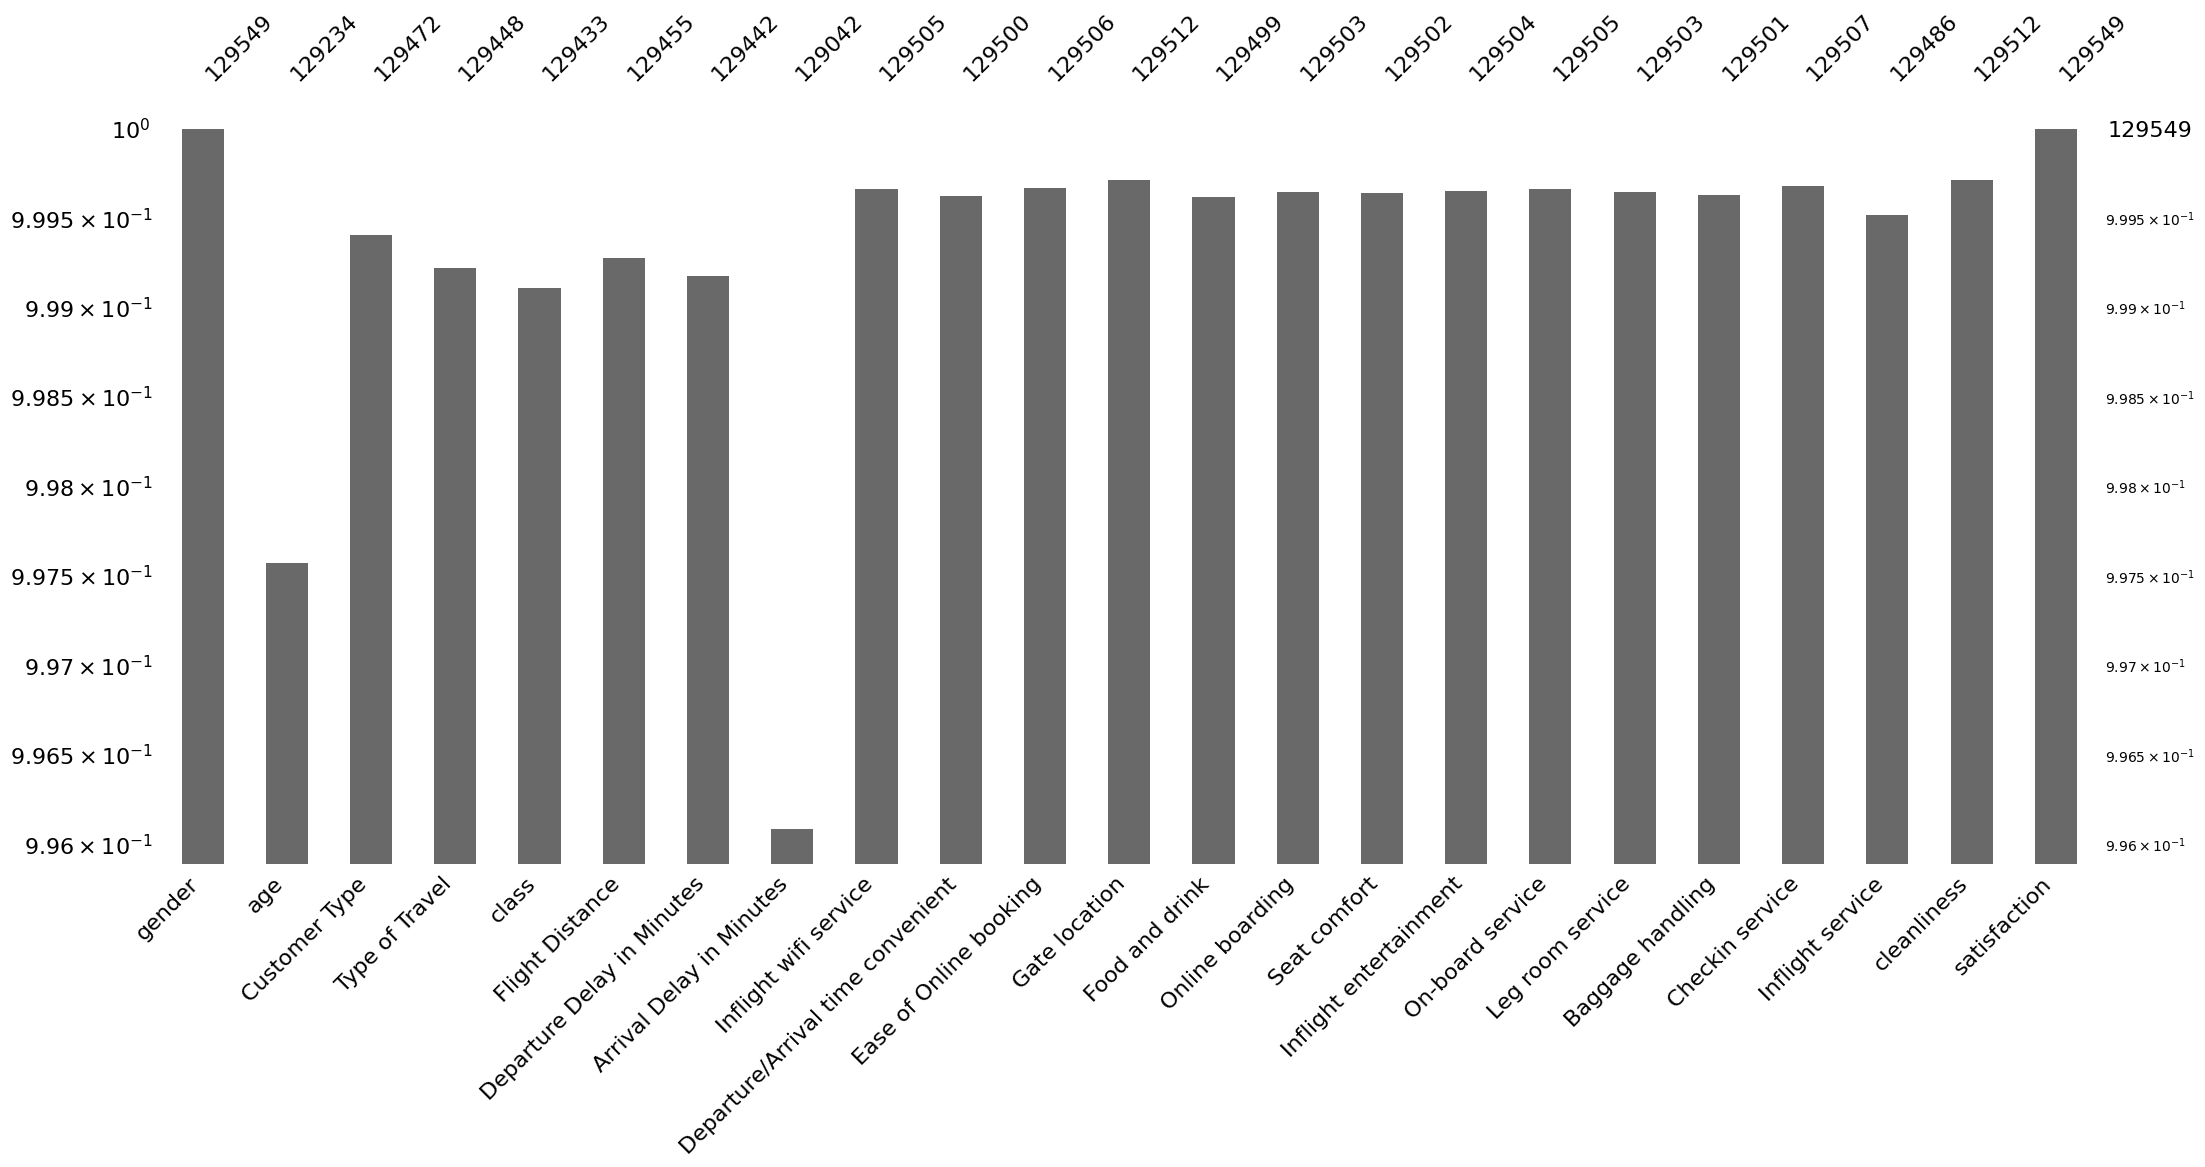

In [18]:
# your code below

missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [19]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [20]:
assert df_train.shape == (103_644, 23)

In [21]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [22]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [23]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [24]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые.

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [25]:
mode = X_train.mode(axis=0)

In [26]:
mode

gender   age   Customer Type   Type of Travel     class  Flight Distance  \
0  Female  39.0  Loyal Customer  Business travel  Business            337.0   

   Departure Delay in Minutes  Arrival Delay in Minutes  \
0                         0.0                       0.0   

   Inflight wifi service  Departure/Arrival time convenient  ...  \
0                    3.0                                4.0  ...   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
0             4.0              4.0           4.0                     4.0   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0               4.0               4.0               4.0              4.0   

   Inflight service  cleanliness  
0               4.0          4.0  

[1 rows x 22 columns]

In [27]:
# your code below

X_train = X_train.fillna(mode.iloc[0])
X_val = X_val.fillna(mode.iloc[0])
df_test = df_test.fillna(mode.iloc[0])

In [28]:
X_train.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [29]:
# the place for you to code

X_train.describe(include='all')

gender           age   Customer Type   Type of Travel     class  \
count    72550  72550.000000           72550            72550     72550   
unique       2           NaN               2                2         3   
top     Female           NaN  Loyal Customer  Business travel  Business   
freq     36816           NaN           59406            50054     34793   
mean       NaN     40.098856             NaN              NaN       NaN   
std        NaN     20.658196             NaN              NaN       NaN   
min        NaN      0.000000             NaN              NaN       NaN   
25%        NaN     27.000000             NaN              NaN       NaN   
50%        NaN     40.000000             NaN              NaN       NaN   
75%        NaN     51.000000             NaN              NaN       NaN   
max        NaN    544.000000             NaN              NaN       NaN   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count      72550.000000                72550.000000              72550.000000   
unique              NaN                         NaN                       NaN   
top                 NaN                         NaN                       NaN   
freq                NaN                         NaN                       NaN   
mean        1329.018332                   15.859366                 16.645968   
std         4764.369357                   70.861937                 97.990293   
min            0.000000                    0.000000                  0.000000   
25%          413.000000                    0.000000                  0.000000   
50%          844.000000                    0.000000                  0.000000   
75%         1744.000000                   12.000000                 13.000000   
max       379620.000000                 9282.000000              11760.000000   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
count            72550.000000                       72550.000000  ...   
unique                    NaN                                NaN  ...   
top                       NaN                                NaN  ...   
freq                      NaN                                NaN  ...   
mean                 2.733687                           3.065017  ...   
std                  1.362172                           1.552254  ...   
min                  0.000000                           0.000000  ...   
25%                  2.000000                           2.000000  ...   
50%                  3.000000                           3.000000  ...   
75%                  4.000000                           4.000000  ...   
max                 45.000000                          45.000000  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
count     72550.000000     72550.000000  72550.000000            72550.000000   
unique             NaN              NaN           NaN                     NaN   
top                NaN              NaN           NaN                     NaN   
freq               NaN              NaN           NaN                     NaN   
mean          3.209318         3.256513      3.445665                3.362150   
std           1.349963         1.372739      1.346077                1.360862   
min           0.000000         0.000000      0.000000                0.000000   
25%           2.000000         2.000000      2.000000                2.000000   
50%           3.000000         3.000000      4.000000                4.000000   
75%           4.000000         4.000000      5.000000                4.000000   
max          36.000000        32.000000     45.000000               40.000000   

        On-board service  Leg room service  Baggage handling  Checkin service  \
count       72550.000000      72550.000000      72550.000000     72550.000000   
unique               NaN               NaN               NaN              NaN   
top                  NaN               Na

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

# answer here, feel free to change into markdown

Если посмотреть на max значения в числовых столбцах, то можно видеть, что почти везде есть выбросы, и скорее всего это просто ошибки при занесении данных в бд, потому что невозможно, чтобы кому то было 544 года. Возможно где - то просто представлены разные единицы измерения. Учитывая что нет описания входных данных, есть только название признаков, тяжело сказать конкретно по некоторым объектам. Но с уверенностью можно сказать, что есть выбросы, и они несопоставимы со средними значениями

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [30]:
Q = X_train.quantile(0.996)
quantile = np.unique(np.where(X_train > Q)[0])

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


In [31]:
ind = X_train.iloc[quantile].index

In [32]:
X_train.drop(index=ind, inplace=True)

In [33]:
y_train.drop(index=ind, inplace=True)

In [34]:
X_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
2031    Female  29.0  disloyal Customer  Business travel  Business   
11597   Female  45.0     Loyal Customer  Business travel  Business   
74668     Male   8.0     Loyal Customer  Personal Travel       Eco   
31602   Female  48.0     Loyal Customer  Personal Travel       Eco   
51518   Female  25.0  disloyal Customer  Business travel       Eco   
...        ...   ...                ...              ...       ...   
63360   Female  25.0     Loyal Customer  Personal Travel       Eco   
29678     Male  77.0     Loyal Customer  Business travel  Eco Plus   
118743  Female  31.0     Loyal Customer  Personal Travel       Eco   
8922      Male  45.0     Loyal Customer  Personal Travel       Eco   
28513   Female  55.0  disloyal Customer  Business travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
2031              785.0                         0.0                       0.0   
11597            3269.0                         0.0                       0.0   
74668            1431.0                         0.0                       0.0   
31602             602.0                         0.0                       0.0   
51518             651.0                         0.0                       0.0   
...                 ...                         ...                       ...   
63360             337.0                         0.0                       0.0   
29678            1448.0                         0.0                       0.0   
118743            304.0                        21.0                      12.0   
8922              661.0                         0.0                       0.0   
28513            1359.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
2031                      2.0                                2.0  ...   
11597                     0.0                                0.0  ...   
74668                     3.0                                1.0  ...   
31602                     4.0                                5.0  ...   
51518                     5.0                                0.0  ...   
...                       ...                                ...  ...   
63360                     1.0                                4.0  ...   
29678                     2.0                                5.0  ...   
118743                    4.0                                4.0  ...   
8922                      4.0                                1.0  ...   
28513                     3.0                                3.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
2031               4.0              2.0           3.0                     4.0   
11597              2.0              2.0           1.0                     3.0   
74668              5.0              3.0           5.0                     5.0   
31602              2.0              5.0           4.0                     4.0   
51518              2.0              5.0           2.0                     2.0   
...                ...              ...           ...                     ...   
63360              4.0              1.0           4.0                     4.0   
29678              2.0              2.0           2.0                     2.0   
118743             1.0              4.0           5.0                     1.0   
8922               2.0              4.0           2.0                     2.0   
28513              3.0              3.0           2.0                     3.0   

        On-board service  Leg room serv

In [35]:
# assert X_train.shape == (71_369, 22) эти ассерты у большинства студентов не проходили
# assert X_val.shape == (30_609, 22) и это совершенно не принципиально
assert df_test.shape == (25_905, 22)

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [36]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [37]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [38]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""

    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 30))
    axes = axes.flatten()

    for i in range(len(cols)):
        sns.countplot(df, x=cols[i], hue=y, ax=axes[i])
        axes[i].set_title(cols[i] + ' - satisfaction graph')
    plt.tight_layout()
    plt.show()

In [39]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30))
    axes = axes.flatten()
    i=0
    plot_num = 0
    while i < len(cols):
        sns.kdeplot(df, x=cols[i], hue=y, ax=axes[plot_num])
        axes[plot_num].set_title(cols[i]+ ' - density kde graph')
        plot_num+=1
        sns.boxplot(df, x=cols[i], hue=y, ax=axes[plot_num])
        axes[plot_num].set_title(cols[i]+ ' box graph')
        plot_num+=1
        i+=1
    plt.tight_layout()
    plt.show()

In [40]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 30))
    axes = axes.flatten()

    for i in range(len(cols)):
        sns.countplot(df, x=cols[i], hue=y, ax=axes[i])
        axes[i].set_title(cols[i] + ' - satisfaction graph')
    plt.tight_layout()
    plt.show()

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

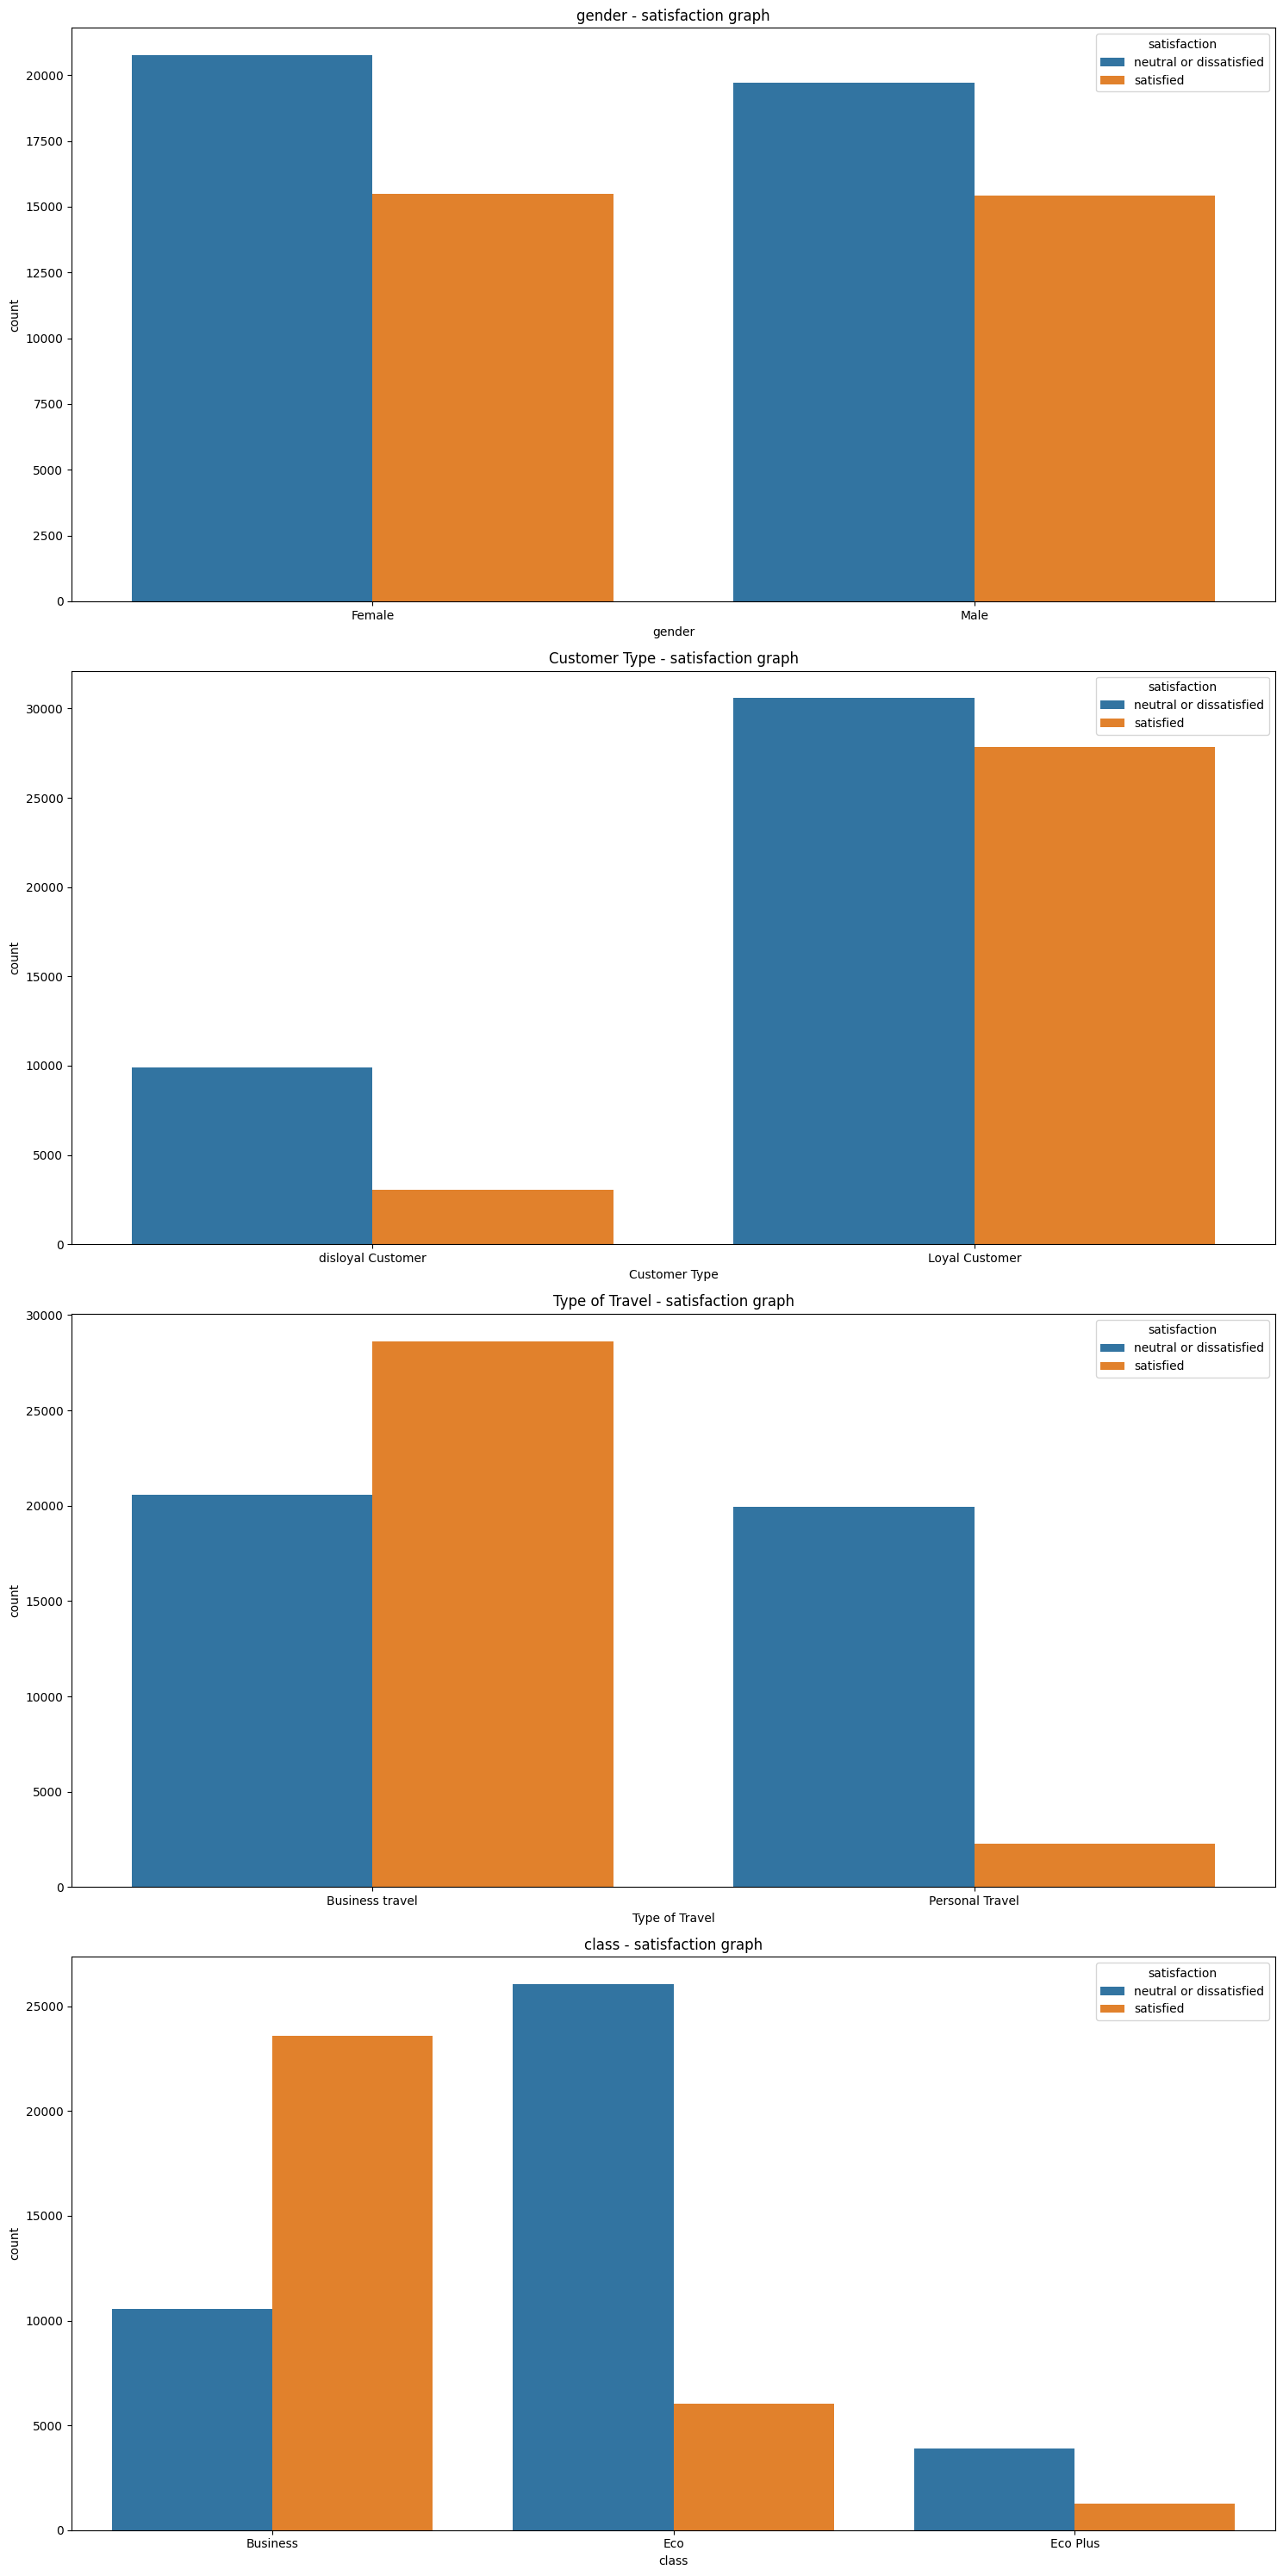

In [41]:
plot_categorical(categorical_cols, X_train, y_train)

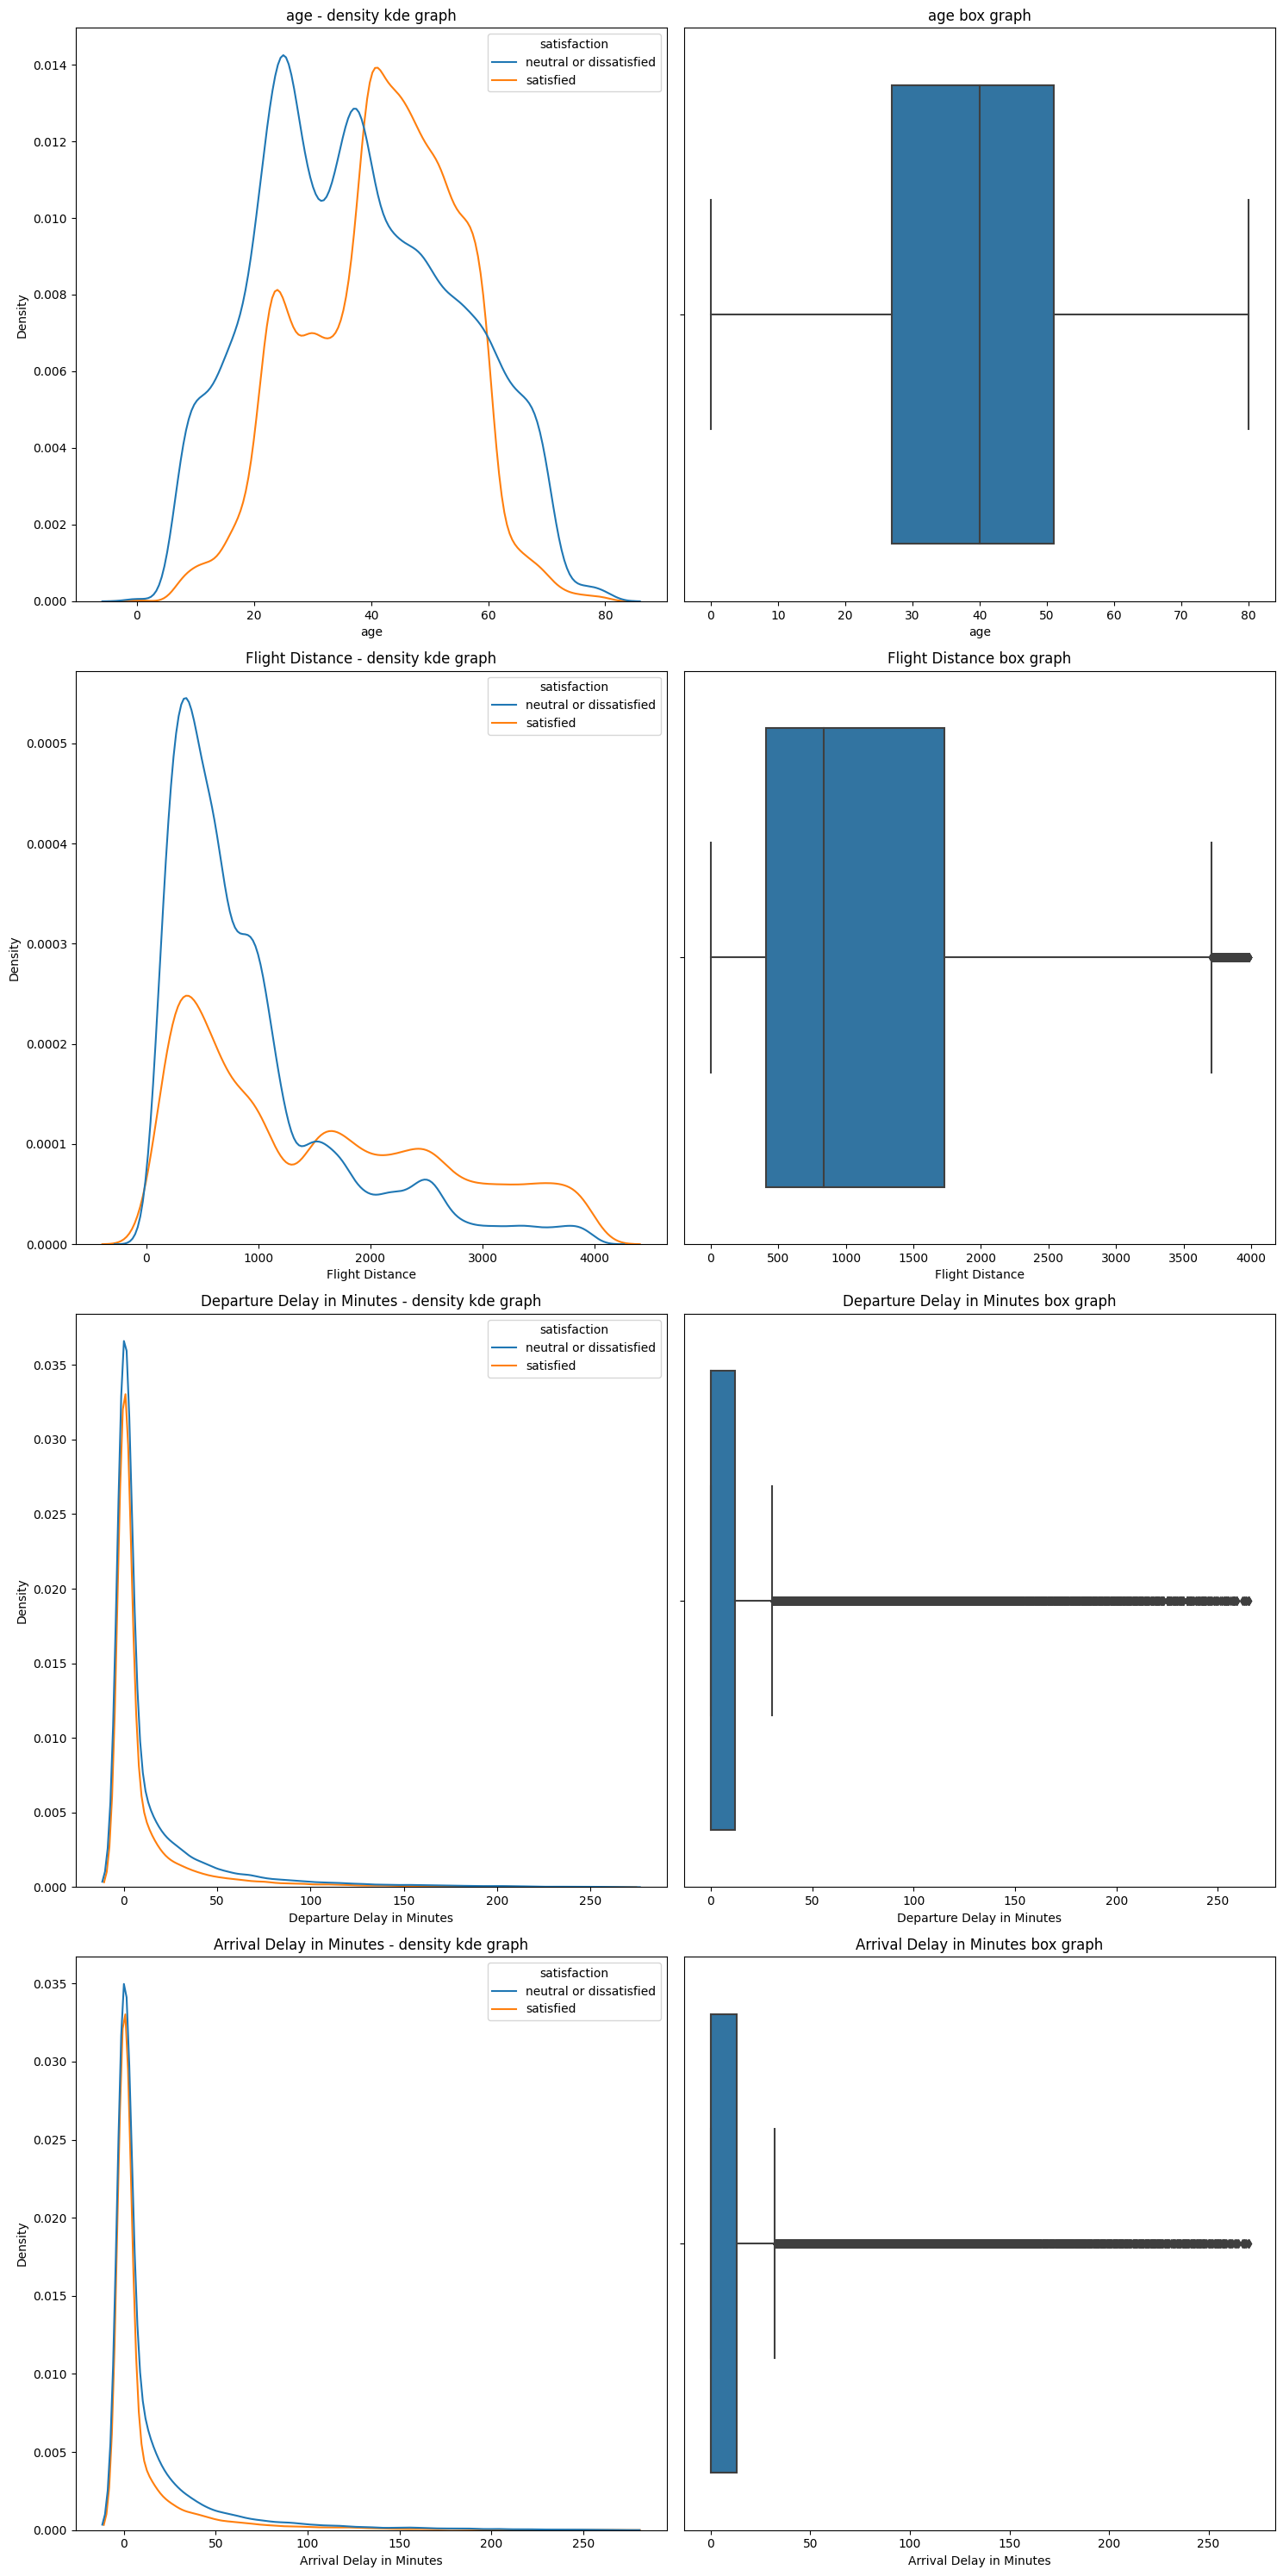

In [42]:
plot_continuous(continuous_cols, X_train, y_train)

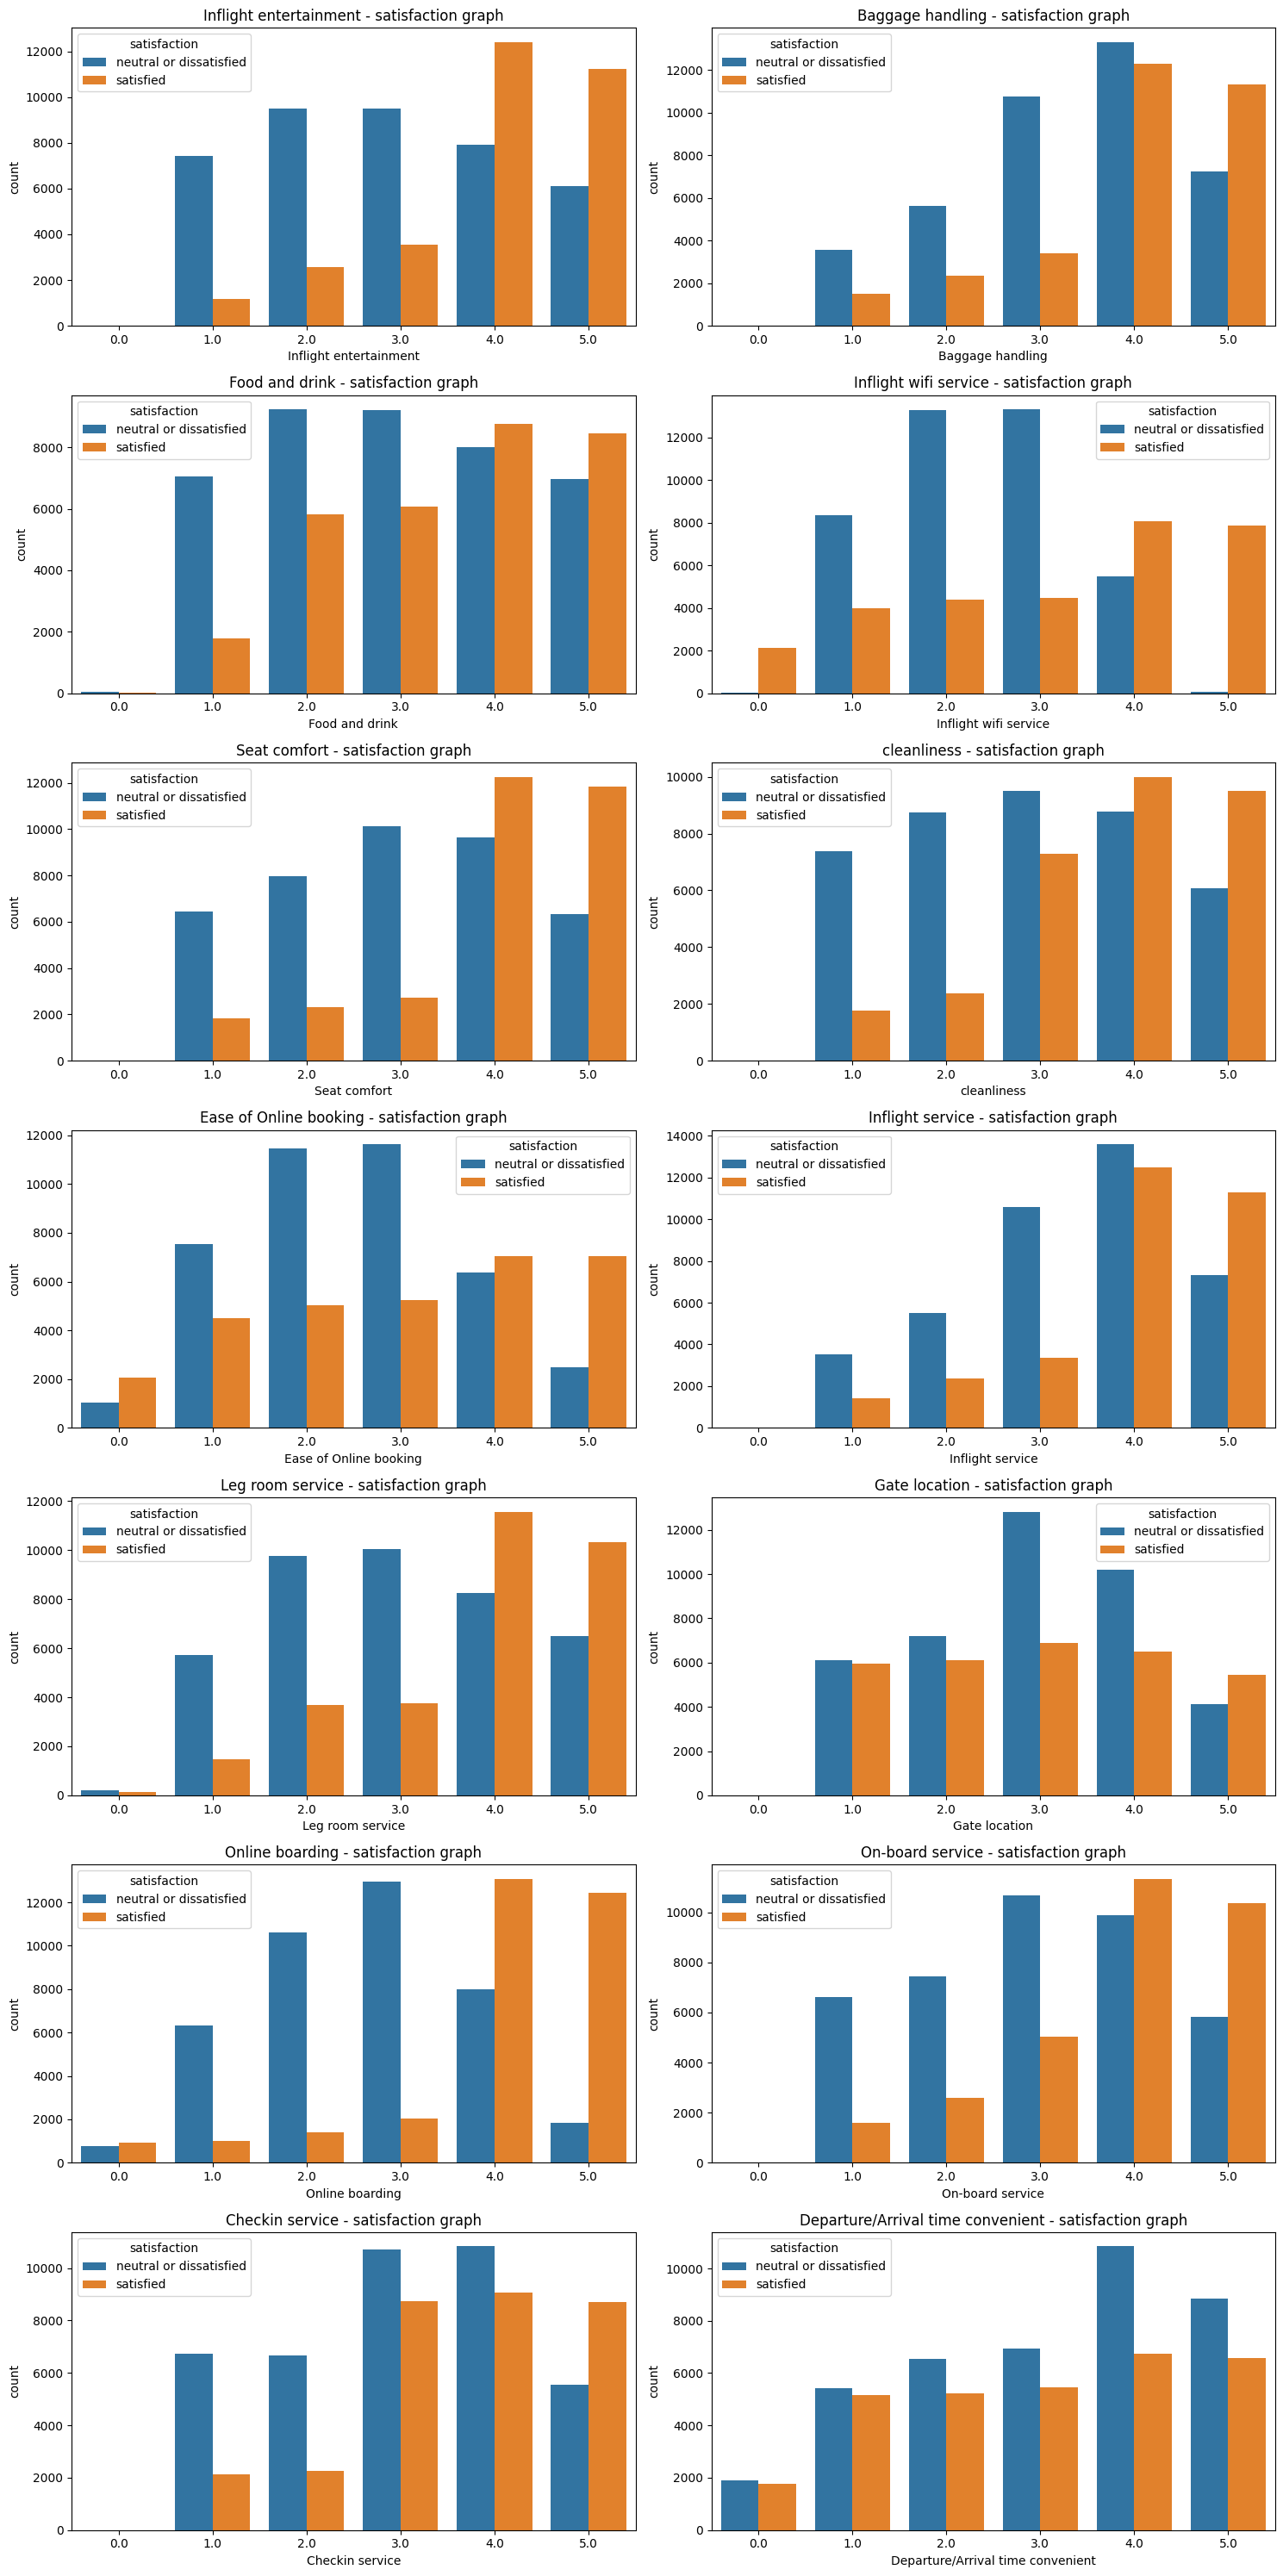

In [43]:
plot_ordinal(ordinal_cols, X_train, y_train)

<Axes: xlabel='satisfaction', ylabel='count'>

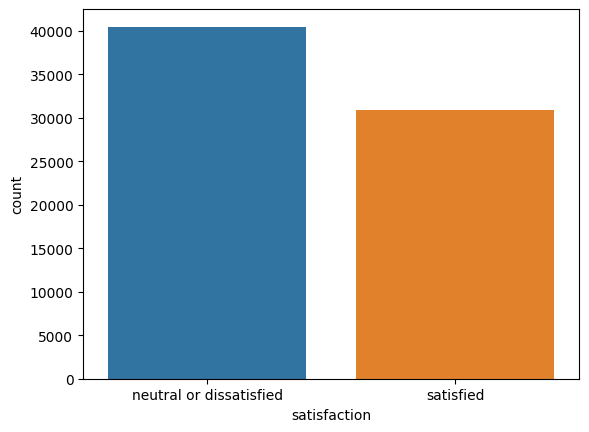

In [44]:
# visualize y_train

sns.countplot(y_train, x=y_train)

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

1. На графиках видно, что люди, которые путешествуют для себя (personal travel), очень редко ставят оценки о качестве обслуживания, либо чаще остаются недовольны сервисом. \
2. Люди, которые путешествуют бизнес классом, почти часто остаются довольными полетом \
3. График удволетсворенности относительно дистанции полета распределен неравномерно \
4. Также графики удволетворенности относительно задержи на посадку и задержки перед презимлением распределены неравномерно и имеют большие выбросы \
5. Также люди очень часто оставались удволетворены, если сервис онлайн посадки был на хорошем уровне \
6. Многим людям понравился полет, если количество вместимого багажа имело большие значения \
7. Многим не понравилось, если в салоне было грязно, была невкусная еда и напитки \
8. Также многим непонравилось, если на борту были неудобные сиденья и мало сервиса для развлечений во время полета. \
9. В основном классы не были сбалансированы. Если сервис плохой, то много плохих/нейтральных оценок и мало хороших. Если сервис хороший, то много хороших оценок и мало плохих/нейтральных \
10. В таргете классы хорошо сбалансированы, нет такого, что одна выборка в разы больше другой
Континуальные признаки - это возраст, дистанция полета и задержка при посадке в самолет и при посадке во время полета

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

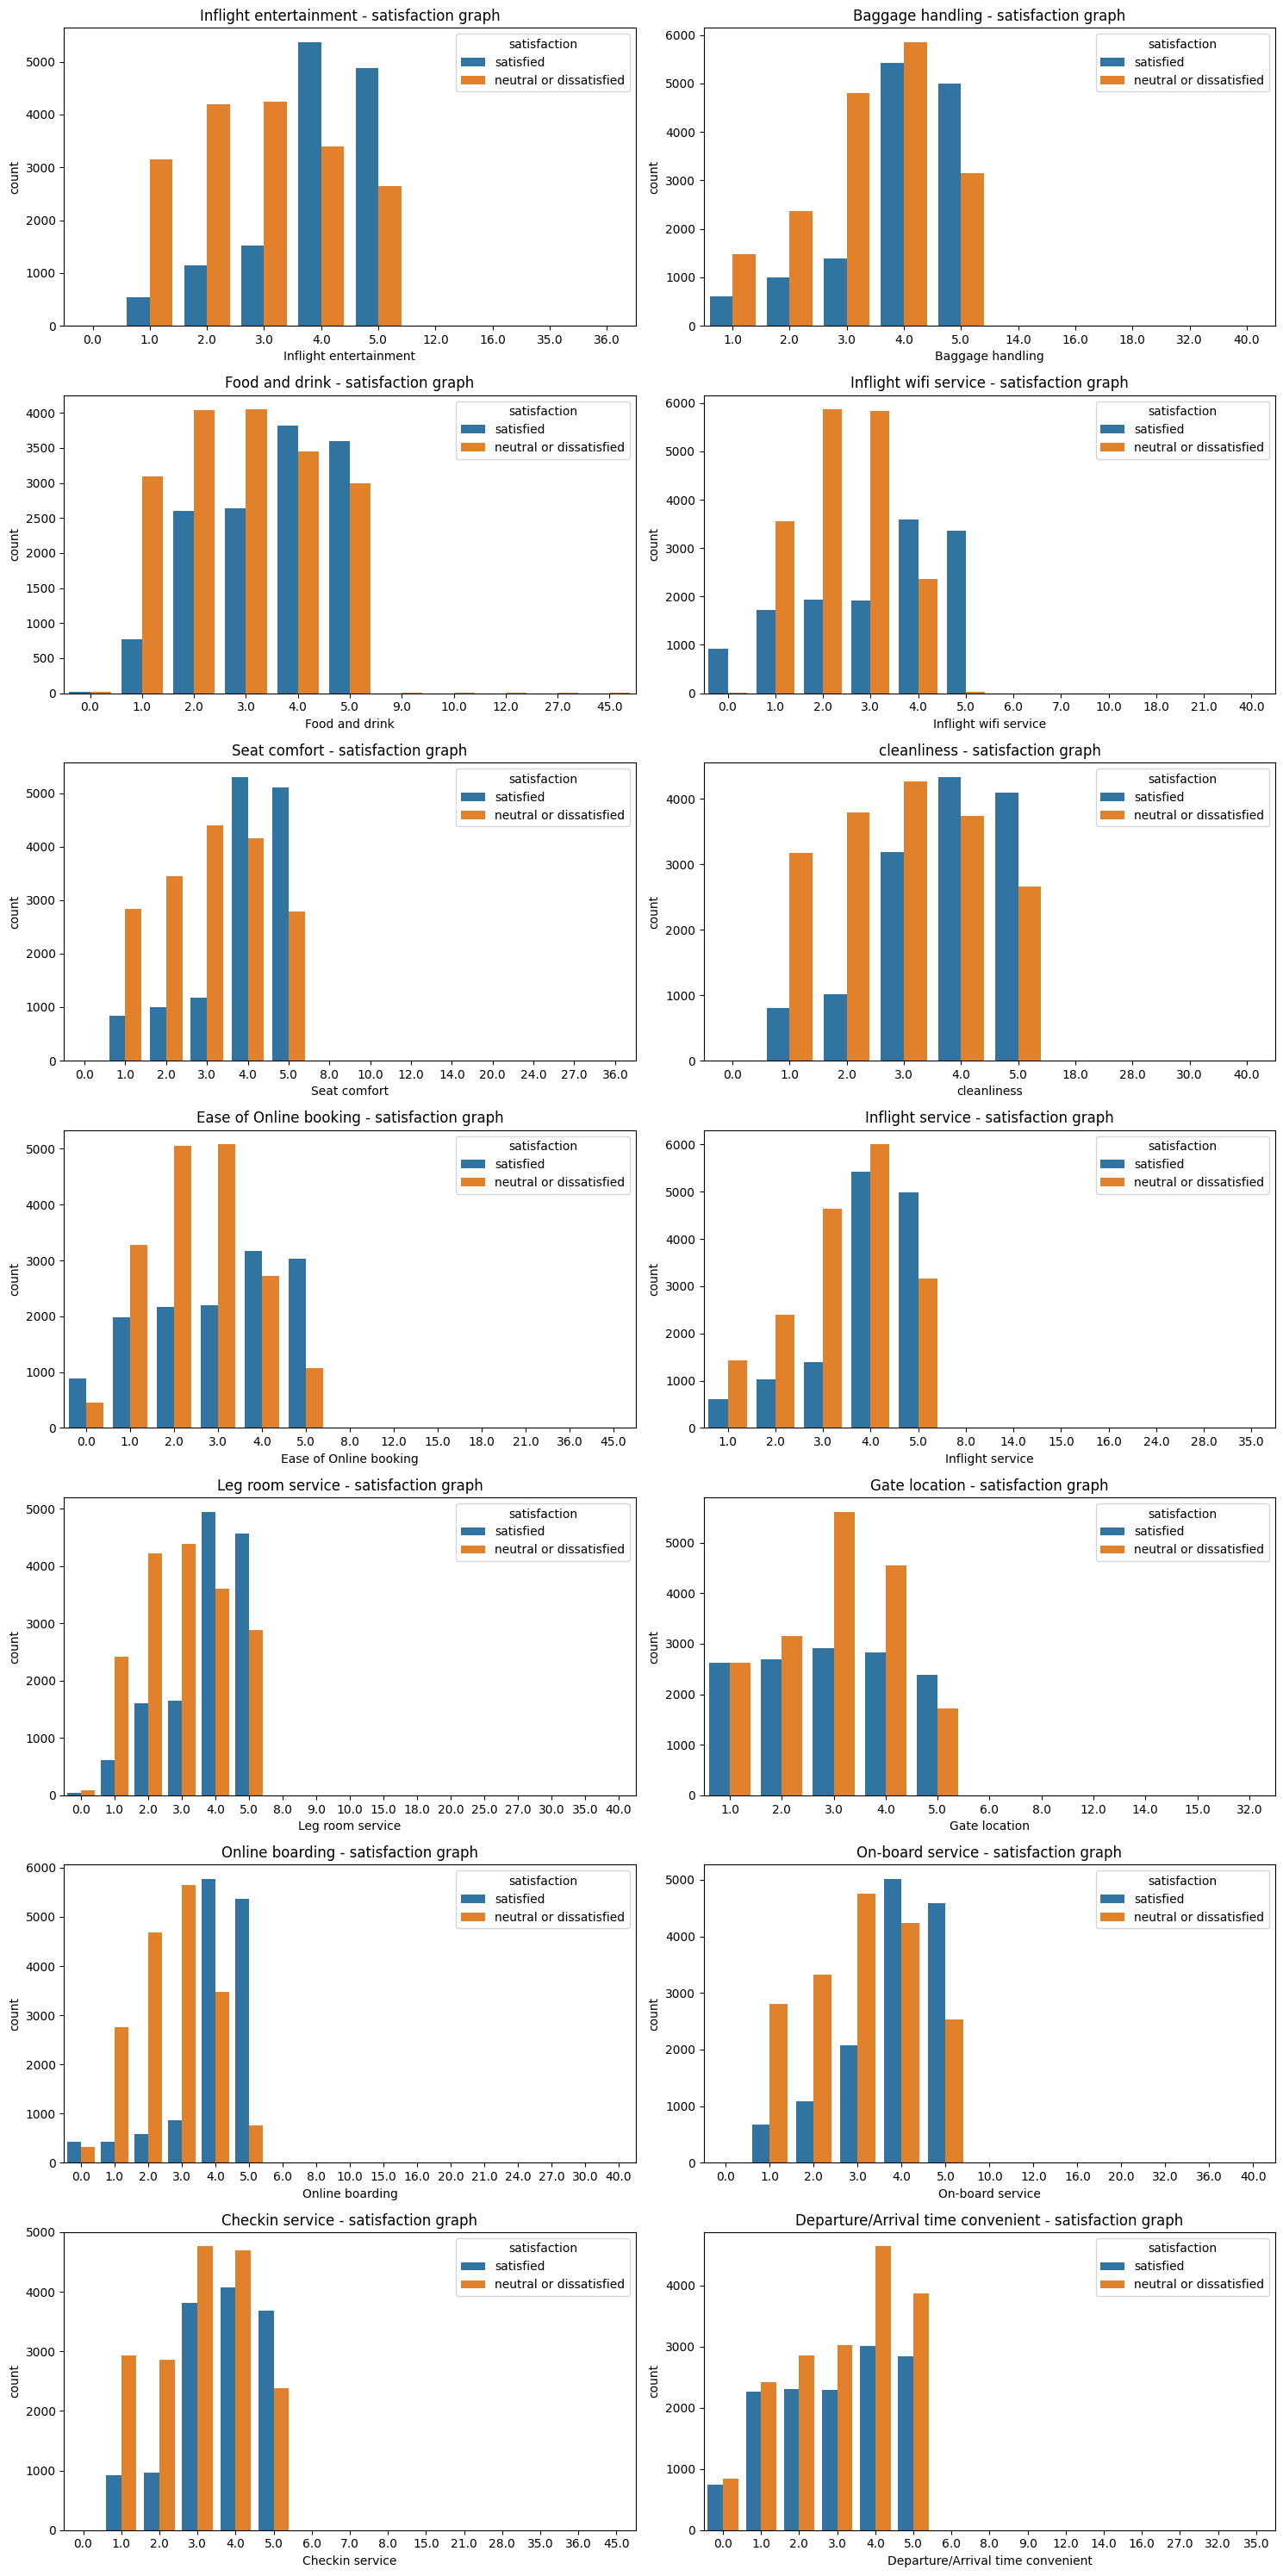

In [45]:
# your code below

plot_ordinal(ordinal_cols, X_val, y_val)

***Распределения на трейне и валидации оказались достаточно схожими, что можно заметить по рядку графиков, например: \
Seat comfort graph, Leg room service graph, online boarding graph и тд.***

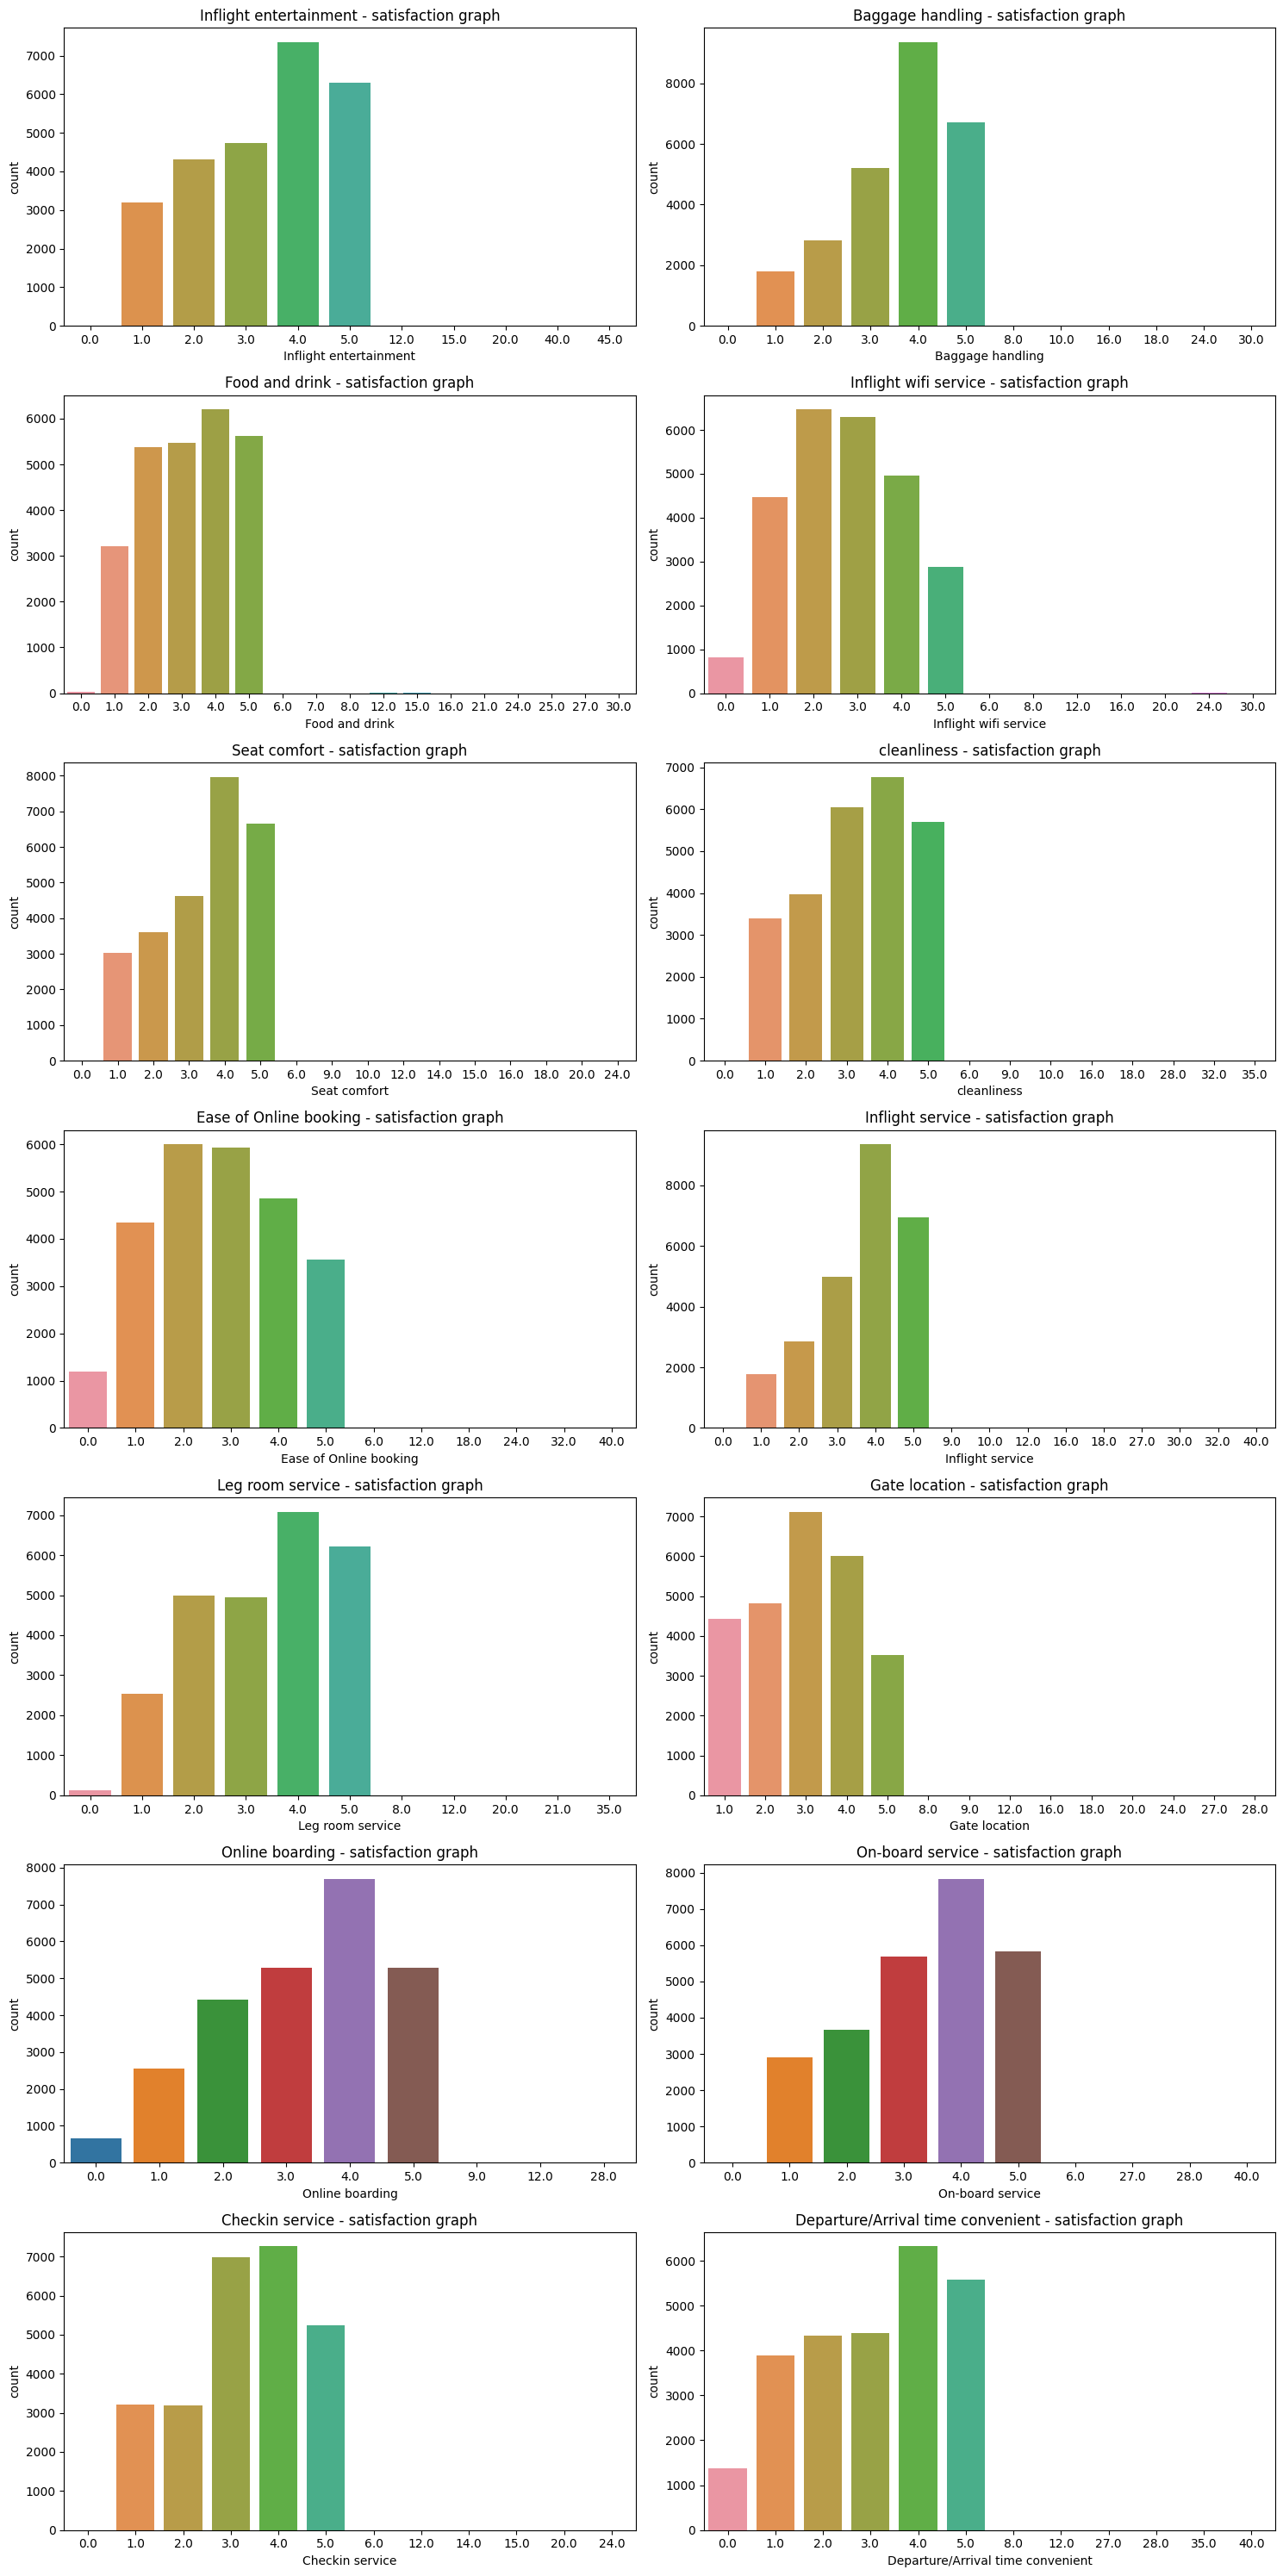

In [46]:
plot_ordinal(ordinal_cols, df_test, None)

***Тоже самое можно сказать и о тестовой выборке. Можно заметить что распределения очень схожи с графиками, построенными выше***

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [47]:
# your code
log_cols = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
X_train[log_cols] = np.log(X_train[log_cols] + 1)

In [48]:
X_val[log_cols] = np.log(X_val[log_cols] + 1)

In [49]:
df_test[log_cols] = np.log(df_test[log_cols] + 1)

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

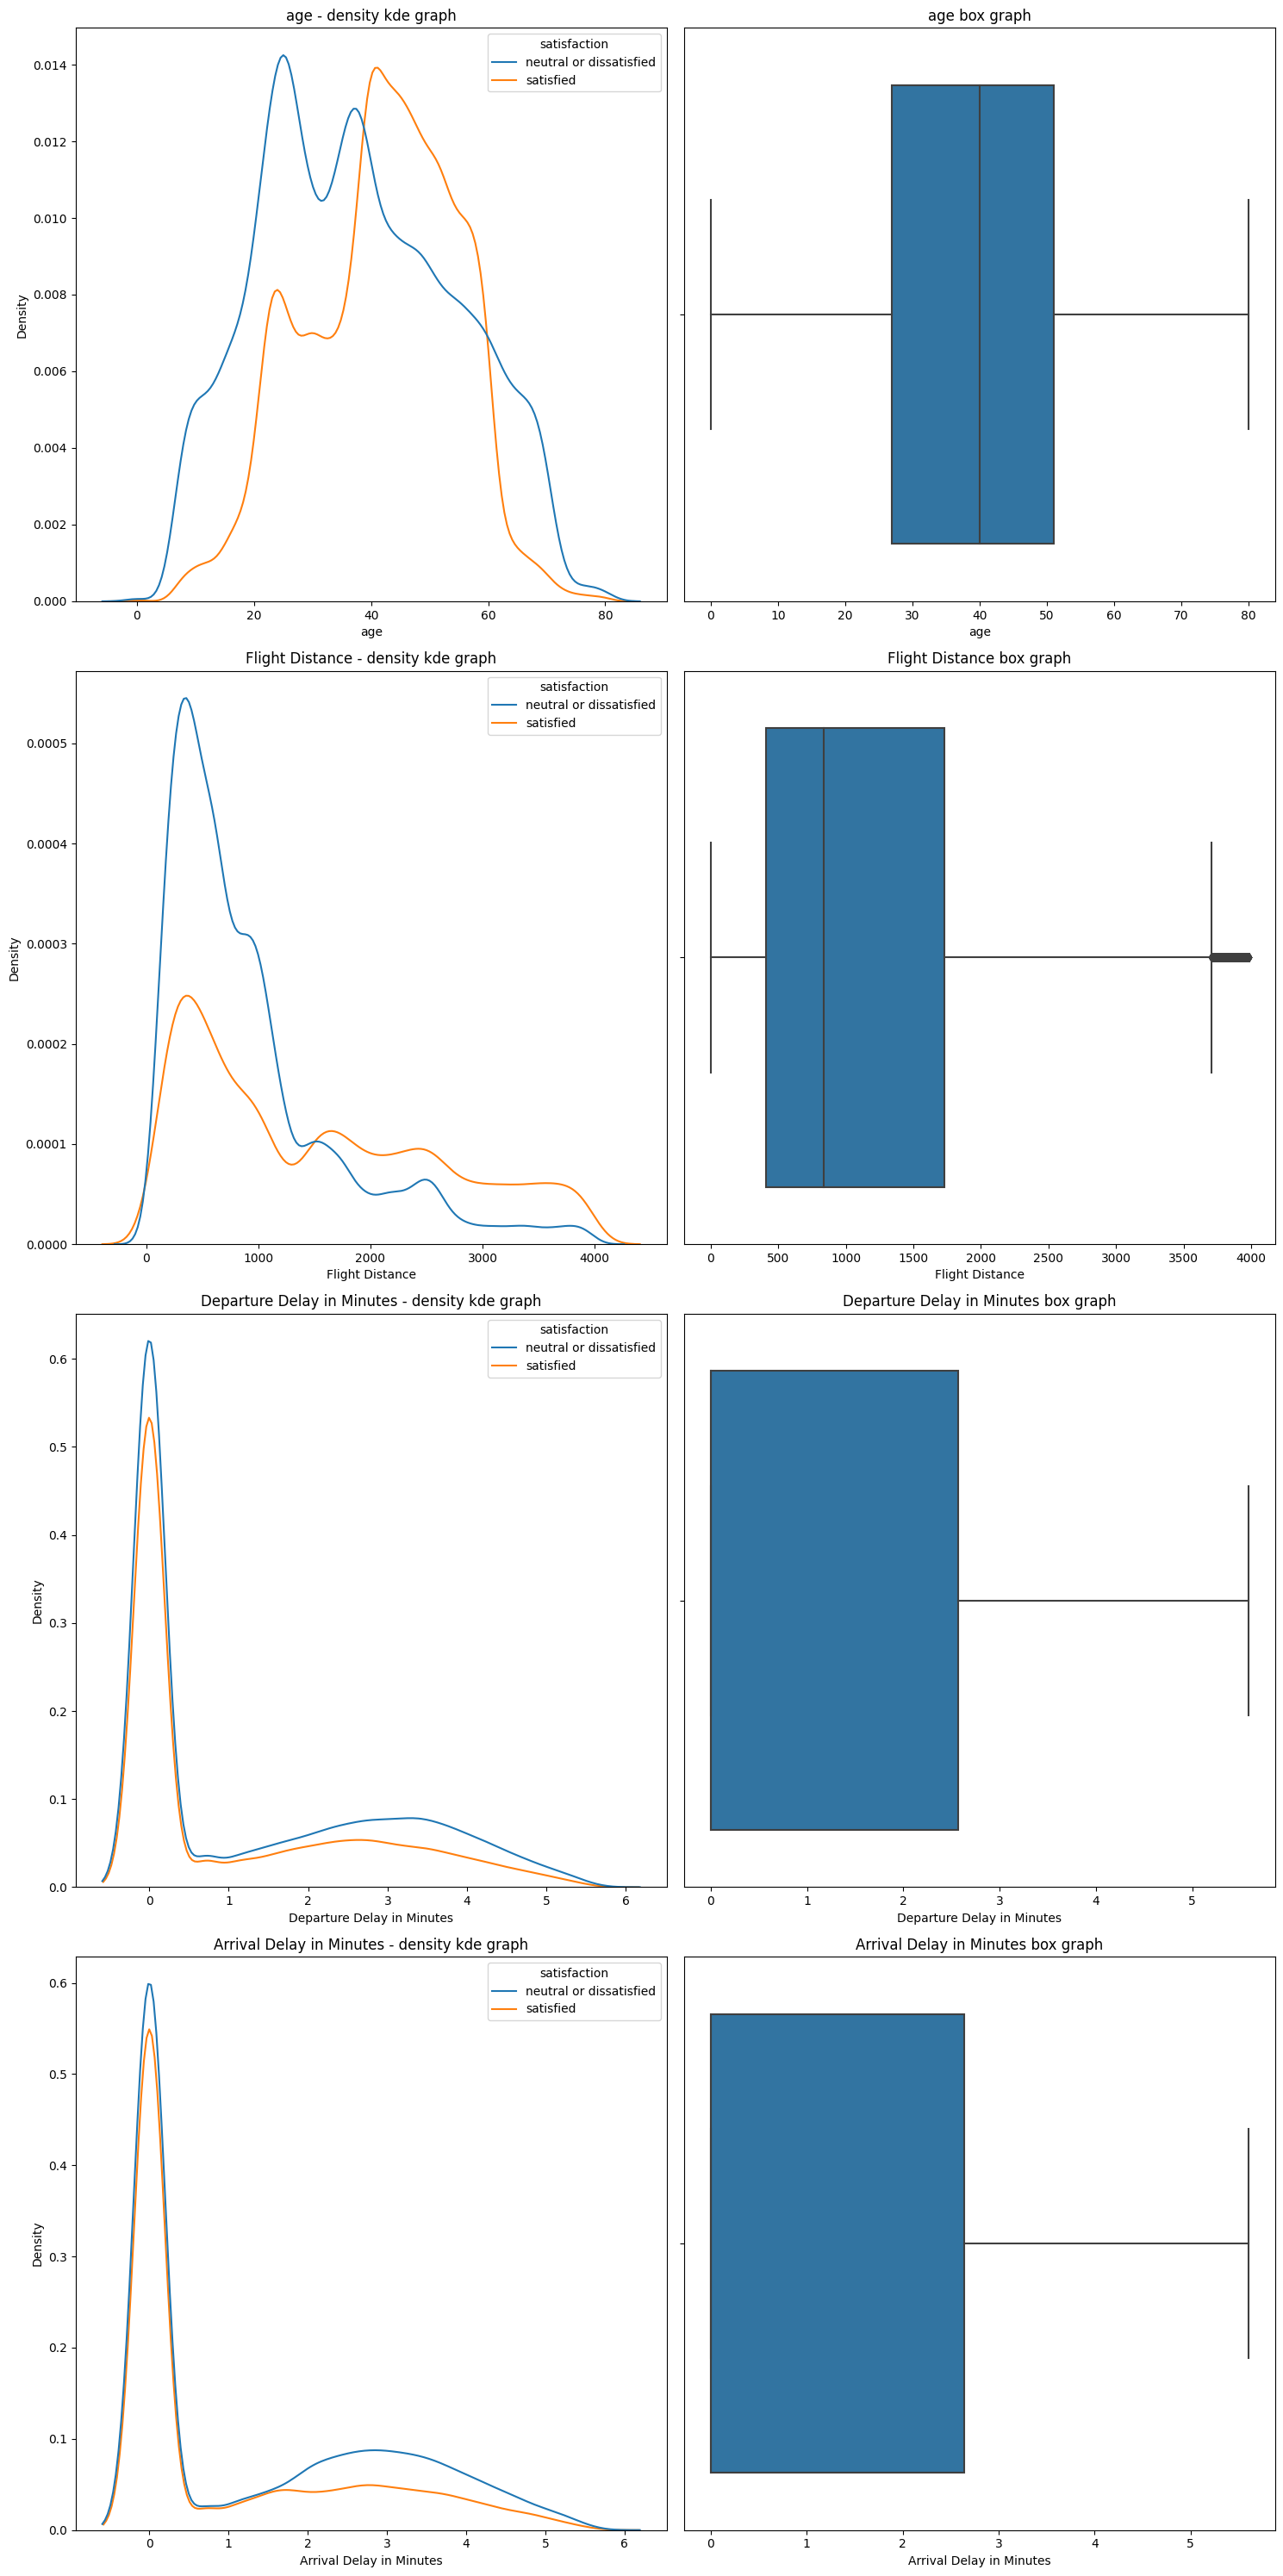

In [50]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [51]:
# your code
map_f = {'satisfied': 1, 'neutral or dissatisfied': 0}
y_train = y_train.map(map_f)

In [52]:
y_val = y_val.map(map_f)

In [53]:
y_train

id
2031      0
11597     1
74668     0
31602     0
51518     1
         ..
63360     0
29678     0
118743    0
8922      1
28513     0
Name: satisfaction, Length: 71395, dtype: int64

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [54]:
merged = X_train[continuous_cols].merge(y_train, on='id')

In [55]:
merged

age  Flight Distance  Departure Delay in Minutes  \
id                                                          
2031    29.0            785.0                    0.000000   
11597   45.0           3269.0                    0.000000   
74668    8.0           1431.0                    0.000000   
31602   48.0            602.0                    0.000000   
51518   25.0            651.0                    0.000000   
...      ...              ...                         ...   
63360   25.0            337.0                    0.000000   
29678   77.0           1448.0                    0.000000   
118743  31.0            304.0                    3.091042   
8922    45.0            661.0                    0.000000   
28513   55.0           1359.0                    0.000000   

        Arrival Delay in Minutes  satisfaction  
id                                              
2031                    0.000000             0  
11597                   0.000000             1  
74668                   0.000000             0  
31602                   0.000000             0  
51518                   0.000000             1  
...                          ...           ...  
63360                   0.000000             0  
29678                   0.000000             0  
118743                  2.564949             0  
8922                    0.000000             1  
28513                   0.000000             0  

[71395 rows x 5 columns]

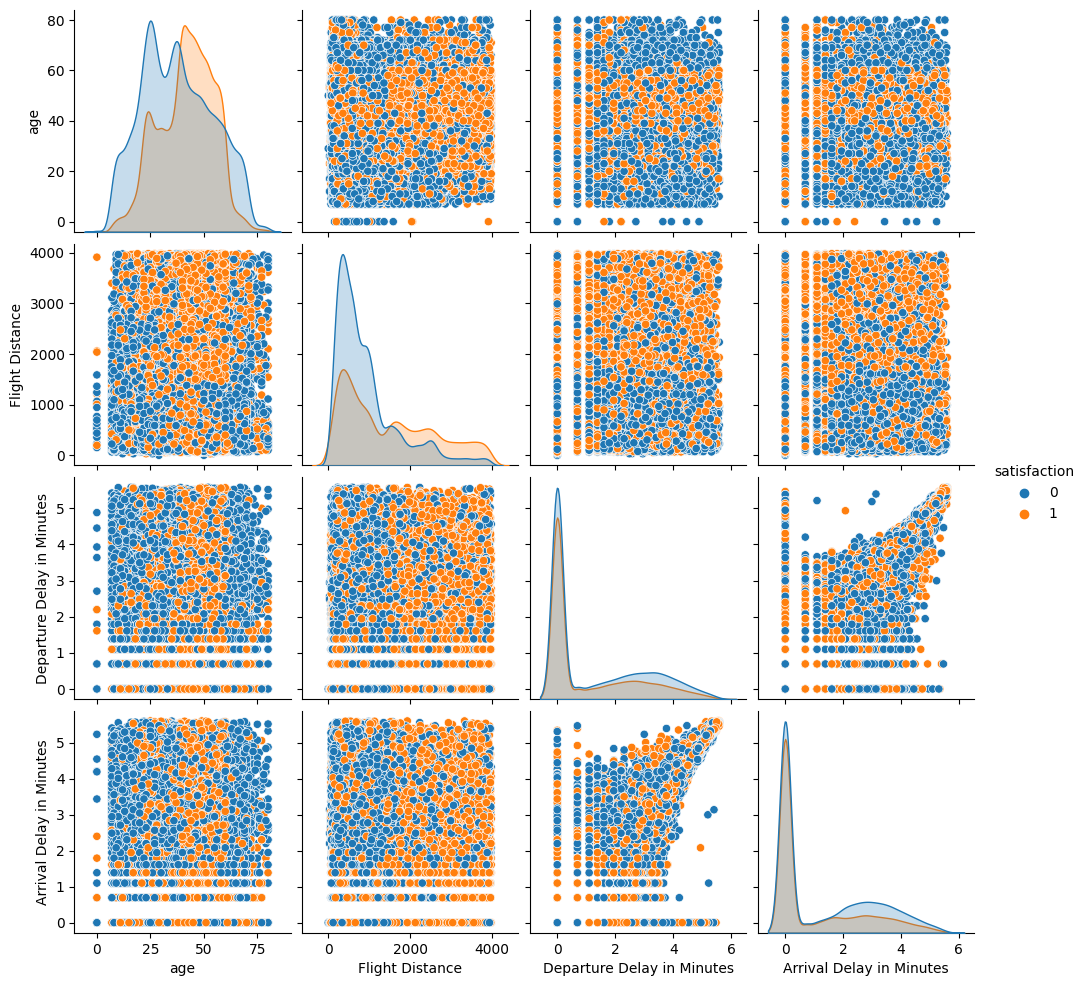

In [56]:
# your code

sns.pairplot(data = merged, hue='satisfaction')

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [57]:
# your code below

ohe = OneHotEncoder()
X_train[ohe.get_feature_names_out()] = ohe.fit_transform(X_train[categorical_cols]).toarray()
X_val[ohe.get_feature_names_out()] = ohe.transform(X_val[categorical_cols]).toarray()
new_cat_names = ohe.get_feature_names_out()

In [58]:
X_train = X_train.drop(categorical_cols, axis = 1)
X_val = X_val.drop(categorical_cols, axis = 1)

In [59]:
X_train

age  Flight Distance  Departure Delay in Minutes  \
id                                                          
2031    29.0            785.0                    0.000000   
11597   45.0           3269.0                    0.000000   
74668    8.0           1431.0                    0.000000   
31602   48.0            602.0                    0.000000   
51518   25.0            651.0                    0.000000   
...      ...              ...                         ...   
63360   25.0            337.0                    0.000000   
29678   77.0           1448.0                    0.000000   
118743  31.0            304.0                    3.091042   
8922    45.0            661.0                    0.000000   
28513   55.0           1359.0                    0.000000   

        Arrival Delay in Minutes  Inflight wifi service  \
id                                                        
2031                    0.000000                    2.0   
11597                   0.000000                    0.0   
74668                   0.000000                    3.0   
31602                   0.000000                    4.0   
51518                   0.000000                    5.0   
...                          ...                    ...   
63360                   0.000000                    1.0   
29678                   0.000000                    2.0   
118743                  2.564949                    4.0   
8922                    0.000000                    4.0   
28513                   0.000000                    3.0   

        Departure/Arrival time convenient  Ease of Online booking  \
id                                                                  
2031                                  2.0                     2.0   
11597                                 0.0                     0.0   
74668                                 1.0                     3.0   
31602                                 5.0                     4.0   
51518                                 0.0                     5.0   
...                                   ...                     ...   
63360                                 4.0                     1.0   
29678                                 5.0                     5.0   
118743                                4.0                     4.0   
8922                                  1.0                     4.0   
28513                                 3.0                     3.0   

        Gate location  Food and drink  Online boarding  ...  cleanliness  \
id                                                      ...                
2031              4.0             4.0              2.0  ...          4.0   
11597             3.0             2.0              2.0  ...          1.0   
74668             2.0             5.0              3.0  ...          5.0   
31602             3.0             2.0              5.0  ...          3.0   
51518             2.0             2.0              5.0  ...          2.0   
...               ...             ...              ...  ...          ...   
63360             4.0             4.0              1.0  ...          4.0   
29678             5.0             2.0              2.0  ...          2.0   
118743            1.0             1.0              4.0  ...          1.0   
8922              4.0             2.0              4.0  ...          2.0   
28513             3.0             3.0              3.0  ...          3.0   

        gender_Female  gender_Male  Customer Type_Loyal Customer  \
id                                                                 
2031              1.0          0.0                           0.0   
11597             1.0          0.0                           1.0   
74668             0.0          1.0                           1.0   
31602             1.0          0.0                           1.0   
51518             1.0          0.0                           0.0   
...               ...          ...                           ...   
63360           

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [101]:
# code here

tree = DecisionTreeClassifier()

fitted = tree.fit(X_train, y_train)

pred = fitted.predict(X_val)

accuracy_score(y_val, pred)

0.9417250916575545

## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [61]:
# change *params into what needs to be there by task condition

error_dt, bias_dt, var_dt = bias_variance_decomp(tree,
                                                 X_train=X_train.values,
                                                 X_test=X_val.values,
                                                 y_train=y_train.values,
                                                 y_test=y_val.values,
                                                 loss='0-1_loss')
error_dt, bias_dt, var_dt

(0.06031501254261272, 0.03958963144014922, 0.04463738985013186)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

In [102]:
tree_d = dict(zip(X_train.columns, tree.feature_importances_))

<Axes: >

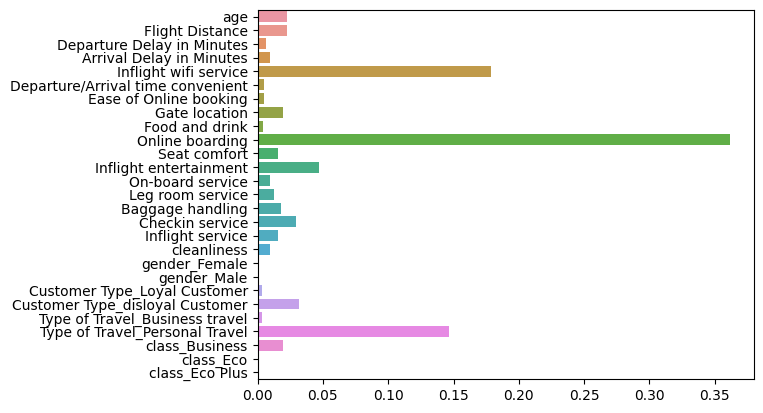

In [104]:
# the place for your code
tree_weights = pd.Series(tree_d)
sns.barplot(y = tree_weights.index, x = tree_weights.values)

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

Самые значимые признаки: **Online boarding, Inflight wifi service и категория business travel**

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [64]:
print("Глубина дерева = ", tree.get_depth())
print("Количество листьев в дереве = ", tree.get_n_leaves())

Глубина дерева =  30
Количество листьев в дереве =  2028


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [65]:
# the place for your solution
most_imp_feat = ['Online boarding', 'Inflight wifi service']

second_tree = DecisionTreeClassifier(max_depth=5)

second_fitted = second_tree.fit(X_train[most_imp_feat], y_train)

second_pred = second_tree.predict(X_val[most_imp_feat])

accuracy_score(y_val, second_pred)

0.8239531742458353

**Качество на валидационной выборке упало на 0.11**

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

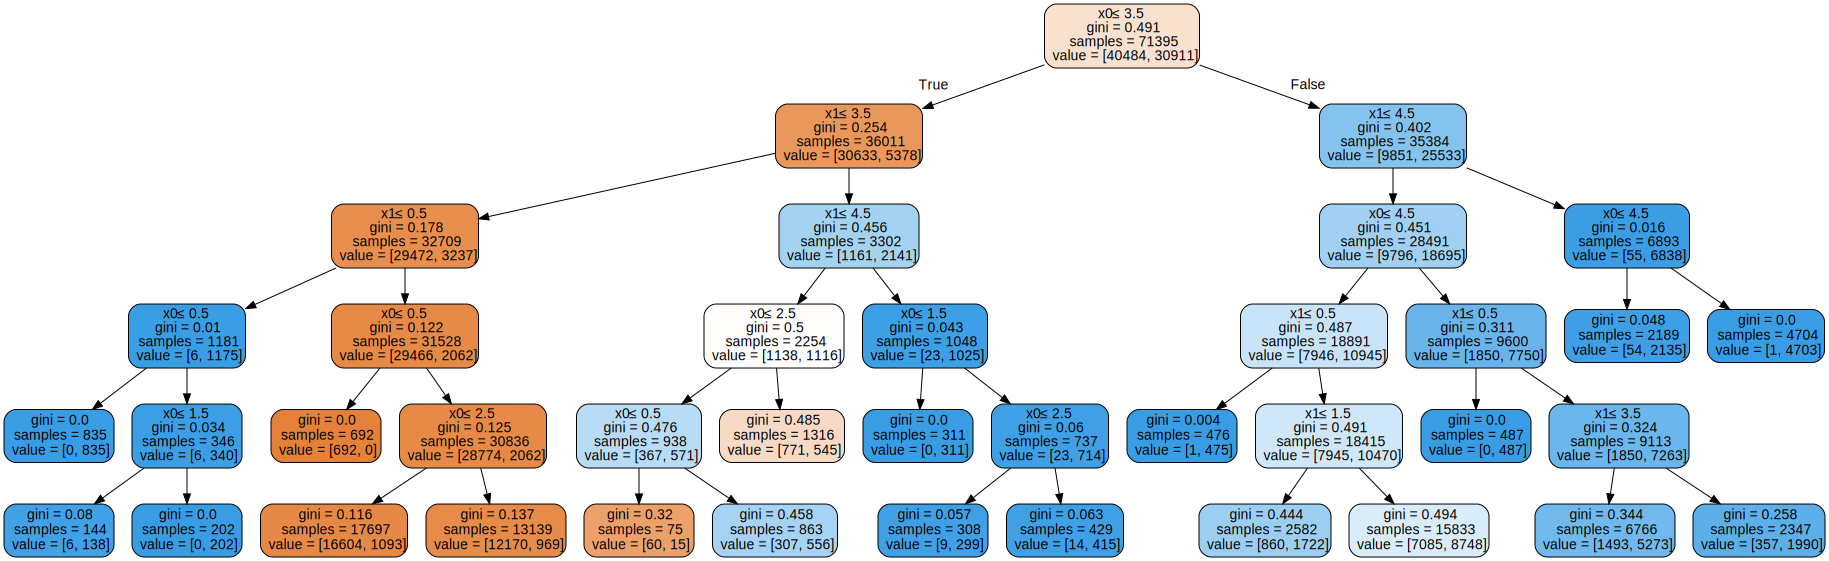

In [66]:
# feel free to google
from sklearn import tree

dot_data = tree.export_graphviz(second_tree,
                  filled=True, rounded=True,
                  special_characters=True,
                  out_file=None,
                  )
graph = Source(dot_data)
graph

**Здесь разбиение на половины происходит для максимизации критерия джини при обучении.**

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [67]:
top_2_cont_feat = np.argpartition(weights[continuous_cols], -2)[:2]
top_2_cont_cols = top_2_cont_feat.keys()
top_2_cont_cols

Index(['age', 'Flight Distance'], dtype='object')

In [68]:
# your code below

cont_tree = DecisionTreeClassifier(max_depth=5)

cont_fitted = cont_tree.fit(X_train[top_2_cont_cols], y_train)

cont_pred = cont_tree.predict(X_val[top_2_cont_cols])

accuracy_score(y_val, cont_pred)

0.6831864668424776

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

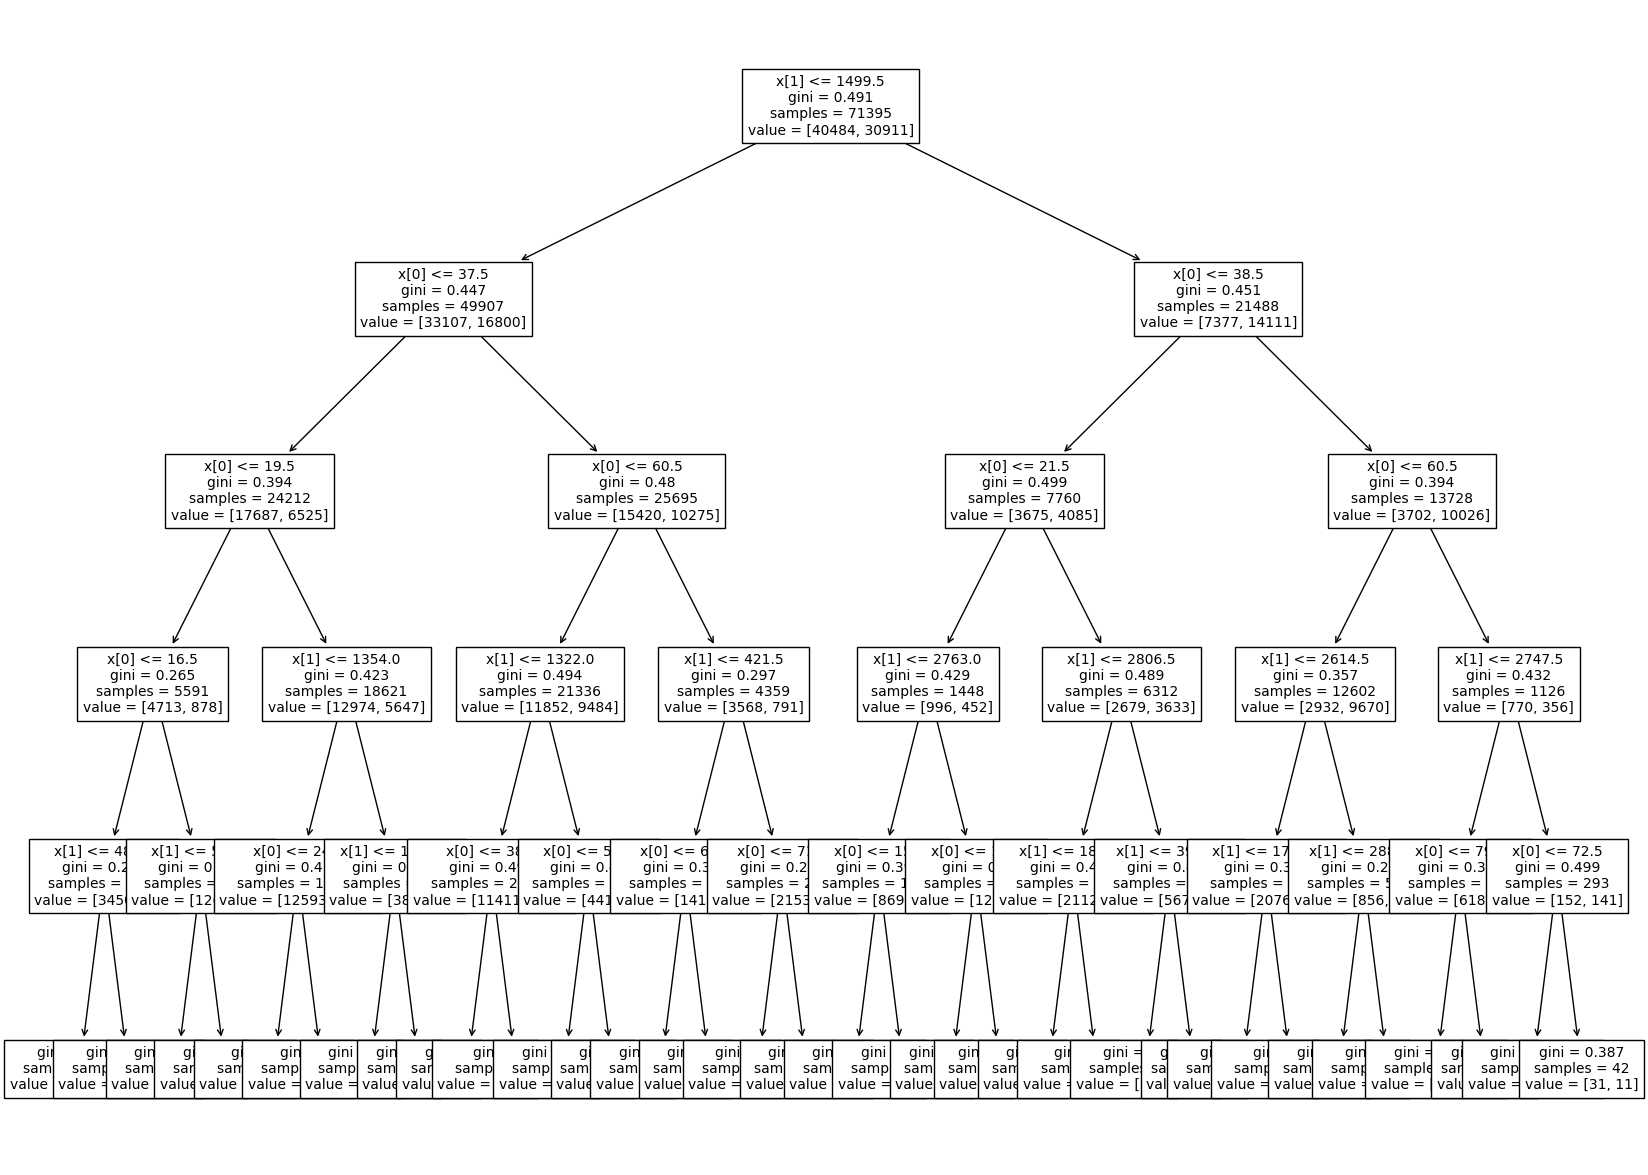

In [69]:
# another place to code a few lines
plt.figure(figsize=(20,15))  # set plot size (denoted in inches)
tree.plot_tree(cont_tree, fontsize=10)
plt.show()

**Деревья получились совсем не симметричные** \

Наверно это не особо имеет значение, учитывая что у нас были использованы разные признаки при построении этих деревьев

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


<Axes: >

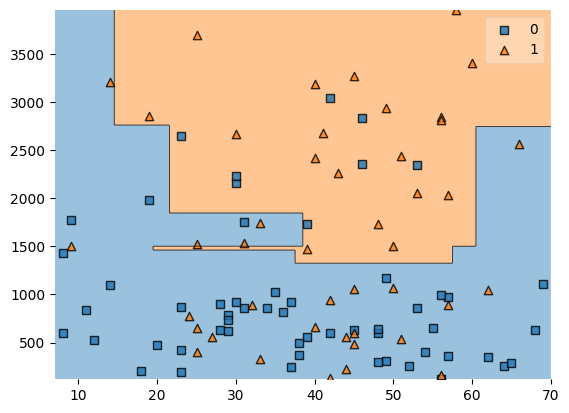

In [70]:
# your line of code
plot_decision_regions(X_train[top_2_cont_cols][:100].values,
                      y_train[:100].values,
                      cont_tree)

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


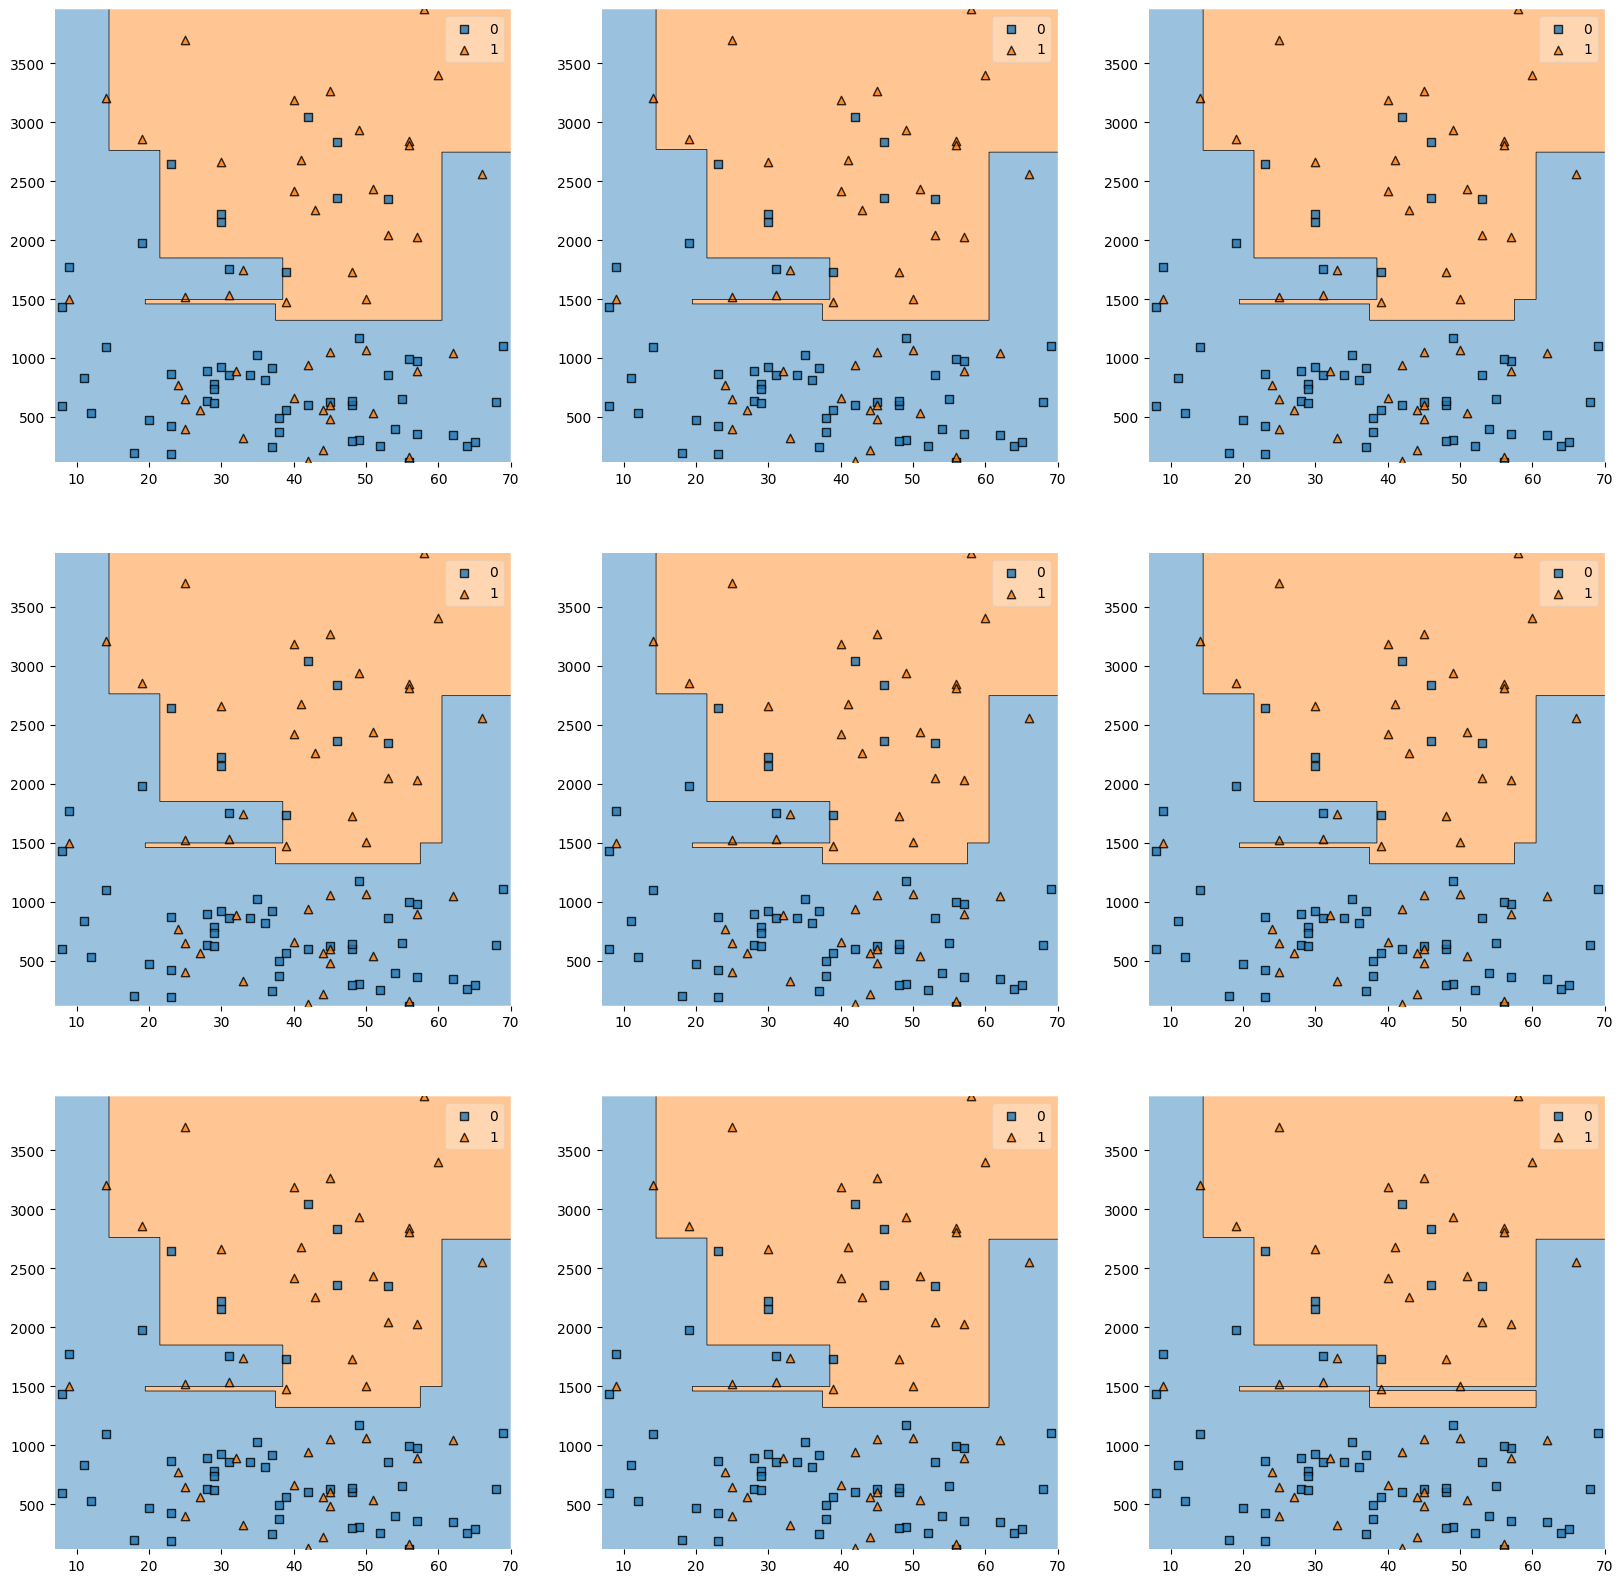

In [71]:
# change X_train_example to your equivalent
X_train_example = X_train[top_2_cont_cols]

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [72]:
# change X_train_enc into your ohe-encoded train set

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 5.2 s, sys: 7.97 ms, total: 5.21 s
Wall time: 5.24 s


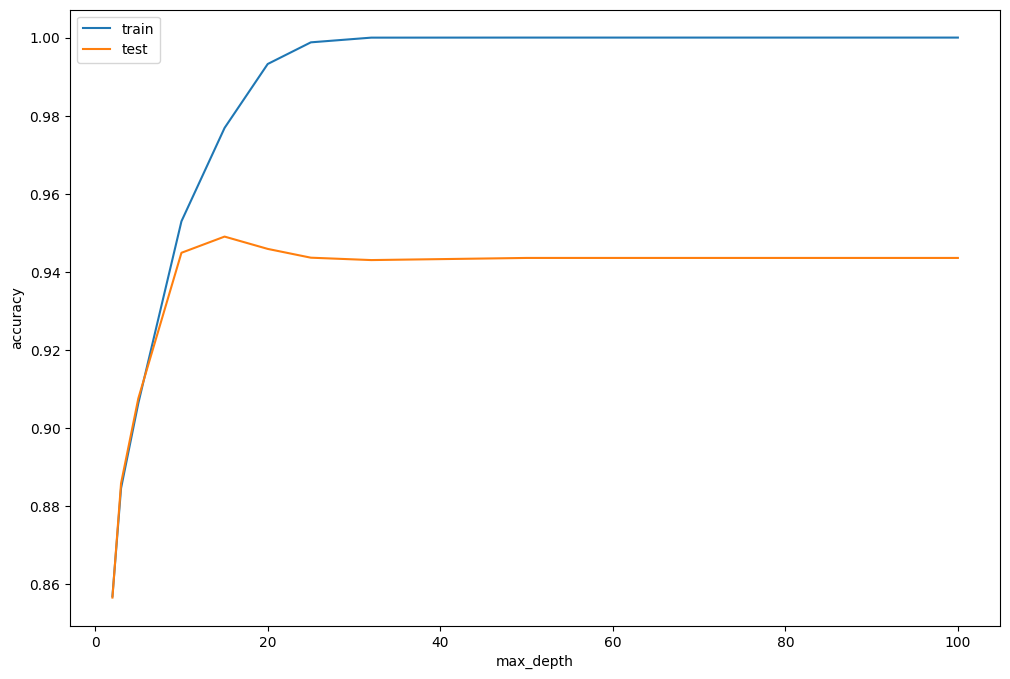

In [73]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [74]:
# you know what to do
des_tree = DecisionTreeClassifier()

params = {'criterion' : ("gini", "entropy", "log_loss"), 'max_depth': [4, 20], 'min_samples_split': [5, 100]}

grid_search = GridSearchCV(des_tree, params)

best_clf = grid_search.fit(X_train, y_train)

best_pred = grid_search.predict(X_val)

accuracy_score(y_val, best_pred)

0.9515662185630668

Качество выросло на 1 сотую. \
Максимальная глубина рассчитывалась по графику максимальной глубины, больше брать смысла не было

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [75]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [76]:
# -__-

rf_clf = RandomForestClassifier()

rf_fitted = rf_clf.fit(X_train, y_train)

pred = rf_clf.predict(X_val)

accuracy_score(y_val, pred)

0.962307840740979

(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

In [77]:
pred_proba = rf_clf.predict_proba(X_val)

In [78]:
pred_proba

array([[0.04, 0.96],
       [0.  , 1.  ],
       [1.  , 0.  ],
       ...,
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ]])

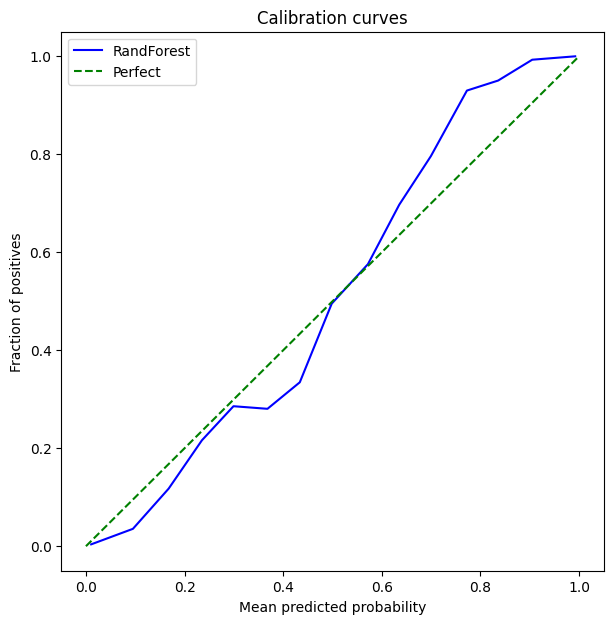

In [79]:
# some lines of your code
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

plt.figure(figsize=(7, 7))

rf_true_prob, rf_pred_prob = calibration_curve(y_val, pred_proba[:,1], n_bins=15)

plt.plot(rf_pred_prob, rf_true_prob, label='RandForest', color='blue')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

RandomForest - это ансамбль решающих деревьев. Внутри каждого решающего дерева все основано на вероятностях, которые мы получаем просто взяв долю объектов класса k в выборке X. \
Так что формально все вероятности основаны на нашей выборке

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

In [80]:
# --____--

log_reg = LogisticRegression(max_iter=10000)

params = {'penalty': ('l1', 'l2', 'elasticnet'), 'C': [1,30]}

log_grid = GridSearchCV(log_reg, param_grid=params)

log_grid_fitted = log_grid.fit(X_train, y_train)

log_pred_proba = log_grid_fitted.predict_proba(X_val)

log_pred = log_grid_fitted.predict(X_val)

accuracy_score(y_val, log_pred)



20 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

-------------------------------------

0.8742522673184537

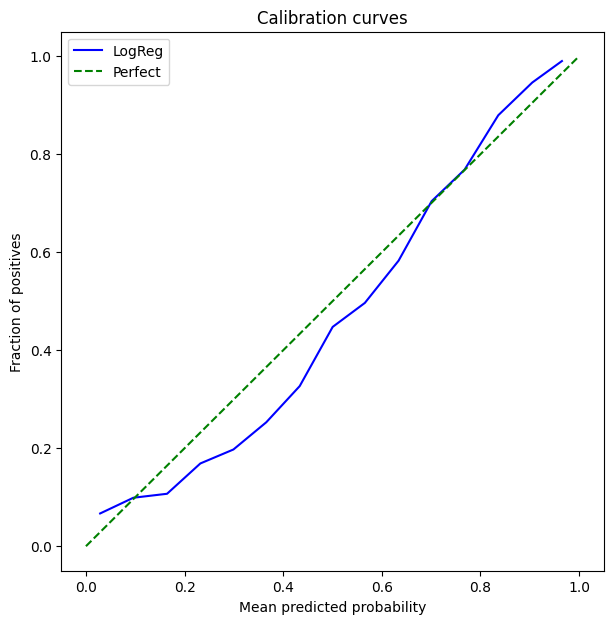

In [81]:
plt.figure(figsize=(7, 7))

log_true_prob, log_pred_prob = calibration_curve(y_val, log_pred_proba[:,1], n_bins=15)

plt.plot(log_pred_prob, log_true_prob, label='LogReg', color='blue')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

Построив логистическую регрессию, мы получаем вектор весов, подобный линейной регрессии. \
Чтобы получить вероятности для вектора таргет переменной, нам достаточно посчитать сигмойду по формуле ниже, где z = <X,w>

In [ ]:
def predict_proba(X, w):
        if w is None:
            raise Exception('Not trained yet')
        return 1 / (1 + np.exp(-(X @ w)))

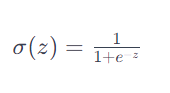

(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

In [83]:
# yet another code cell for logreg
rdf_sig = CalibratedClassifierCV(rf_clf, cv=5)
sig_fitted = rdf_sig.fit(X_train, y_train)
sig_pred_proba = rdf_sig.predict_proba(X_val)

In [97]:
sig_pred = rdf_sig.predict(X_val)
accuracy_score(sig_pred, y_val)

0.9615038271049077

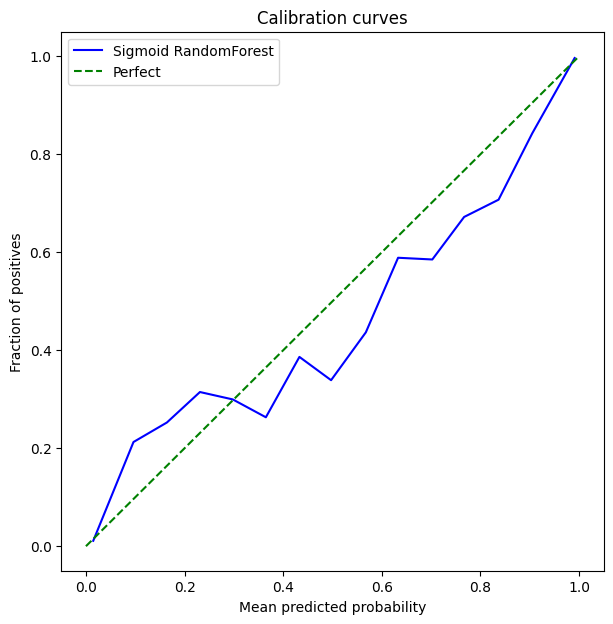

In [84]:
plt.figure(figsize=(7, 7))

sig_true_proba, sig_proba = calibration_curve(y_val, sig_pred_proba[:,1], n_bins=15)

plt.plot(sig_proba, sig_true_proba, label='Sigmoid RandomForest', color='blue')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

**В целом получилось очень даже неплохо, да, где то немного недооцениваем, где то переоцениваем вероятности, но в целом получилось хорошо**

In [85]:
# yet another code cell for isoreg

rdf_iso = CalibratedClassifierCV(rf_clf, cv=5, method='isotonic')
iso_fitted = rdf_sig.fit(X_train, y_train)
iso_pred_proba = rdf_sig.predict_proba(X_val)

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

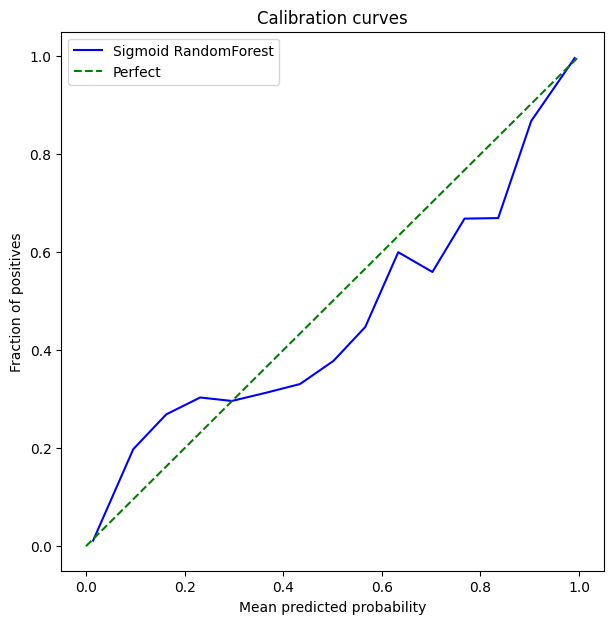

In [86]:
plt.figure(figsize=(7, 7))

iso_true_proba, iso_proba = calibration_curve(y_val, iso_pred_proba[:,1], n_bins=15)

plt.plot(iso_proba, iso_true_proba, label='Sigmoid RandomForest', color='blue')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

**Калибровка изотонических вероятностей получилась вообще супер.\
Да, местами есть разброс, но результат получился отличный**\
*Учитывая пример выше, здесь наглядно видно, что хвост нашего распределения слишком тяжелый, поэтому и получается такой переход при 0.3*

(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [87]:
# one more place for your code

error_rf, bias_rf, var_rf = bias_variance_decomp(rf_clf,
                                                 X_train=X_train.values,
                                                 X_test=X_val.values,
                                                 y_train=y_train.values,
                                                 y_test=y_val.values,
                                                 loss='0-1_loss')
error_rf, bias_rf, var_rf

(0.03946774297292082, 0.03720975107737827, 0.008711326944104973)

В целом тут примерно как и ожидалось по теории:
1. С одной стороны: разница в variance составляет примерно 5 раз. А из теории мы знаем, что смещение в рандом форесте не уменьшается, а разброс уменьшается немного меньше чем в N раз из - за ковариации выборок, при N моделях в ансамбле.
2. С другой стороны по умолчанию у нас стоит 200 бутстрапов -> мы ожидаем более сильного уменьшения variance, нежели только в 5 раз.
3. Но вполне возможно, что мы итак максимально минимизировали разброс, что нам и 200 выборок не было нужно
**Поэтому можно сказать, что наши ожидания совпали с практическими наблюдениями**\
К слову ищется эта штука аж 30 минут!

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [88]:
# (•_•)
logreg_bvd = LogisticRegression(max_iter=10000)

logreg_bvd_f = logreg_bvd.fit(X_train, y_train)

logreg_bvd_pred = logreg_bvd.predict(X_val)

error_log, bias_log, var_log = bias_variance_decomp(logreg_bvd,
                                                 X_train=X_train.values,
                                                 X_test=X_val.values,
                                                 y_train=y_train.values,
                                                 y_test=y_val.values,
                                                 loss='0-1_loss')
error_log, bias_log, var_log

(0.12550701099890657, 0.12568341159066057, 0.004391040072039621)

В целом все довольно очевидно:
1. Большой шум - потому что даже самая идеальная модель линейной классификации не способна хорошо приблизить наши данные. Возможно было бы иначе, если бы мы добавили полиномиальные фичи. \
2. Большое смещение - потому что в среднем наши модели сильно смещены относительно идеальной модели, и хоть построенные нами модели друг от друга и не сильно отличаются, но сильно отличаются от идеальной модели.
3. Маленький разброс - потому что наши модели все очень очень похожи друг на друга.

(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [91]:
# your code here
from scipy.stats import uniform

params = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

log_randcv = LogisticRegression(max_iter=10000)

rndcv_clf = RandomizedSearchCV(log_randcv, params)

rndcv_clf_fitted = rndcv_clf.fit(X_train, y_train)

rndcv_clf_pred = rndcv_clf.predict(X_val)


25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

One or more of the test scores are no

In [92]:
print("Идеальные гиперпараметры: ", rndcv_clf.best_params_)

Идеальные гиперпараметры:  {'C': 3.8378114931944665, 'penalty': 'l2'}


## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [94]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


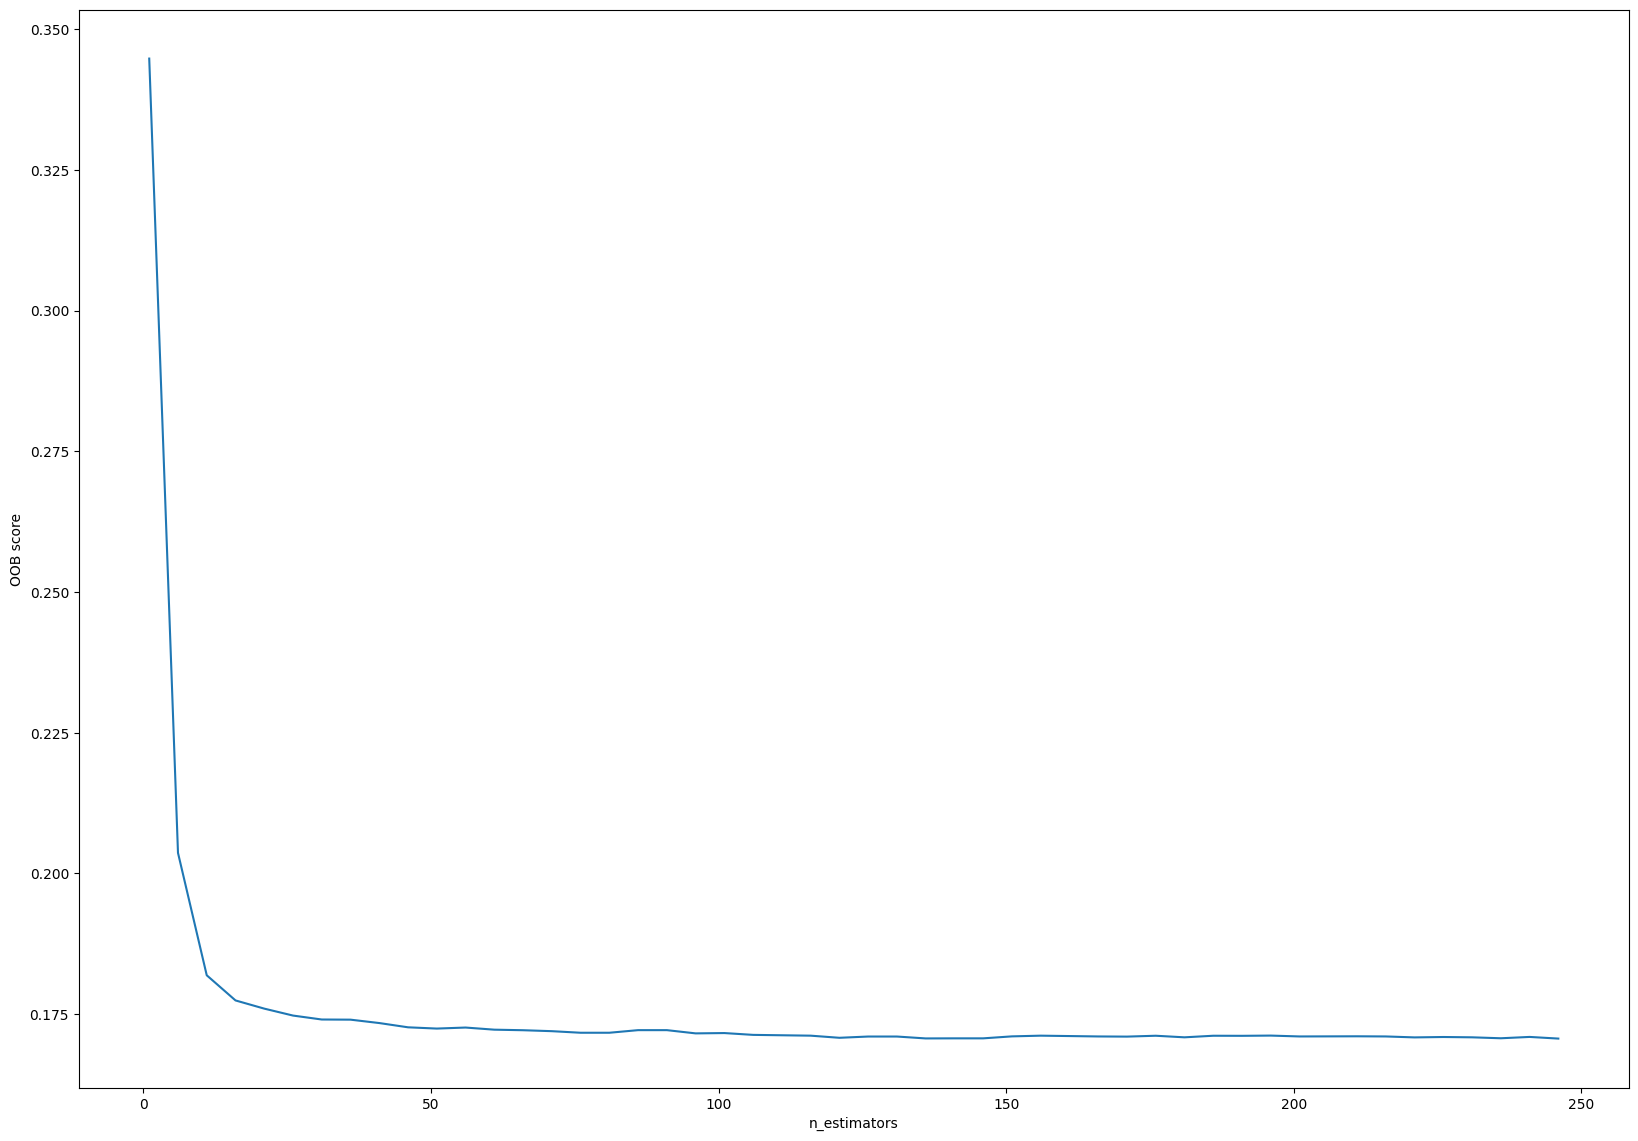

In [95]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

<Axes: >

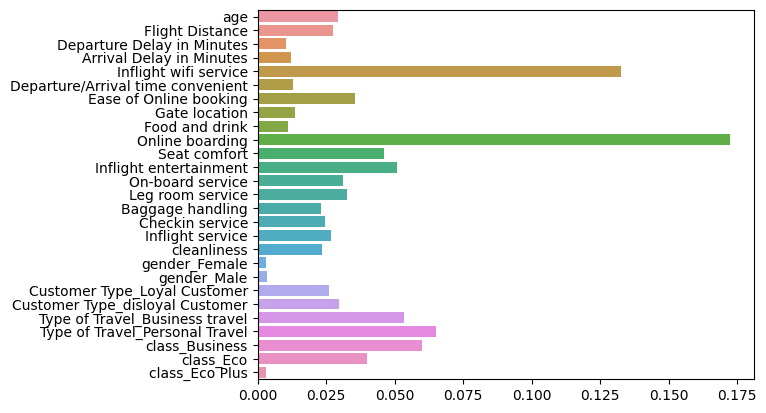

In [105]:
# (•_•)
rf_d = dict(zip(X_train.columns, rf_clf.feature_importances_))
rf_weights = pd.Series(rf_d)
sns.barplot(y = rf_weights.index, x = rf_weights.values)

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [133]:
# -__-
weights_df = pd.DataFrame(data = [tree_weights, rf_weights], columns=rf_weights.index)

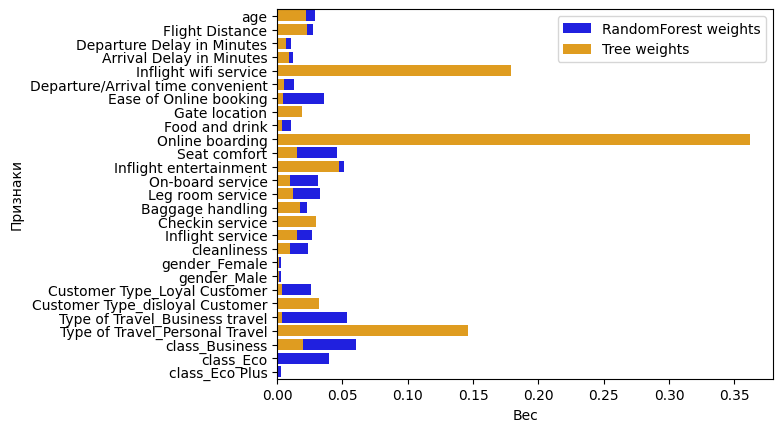

In [138]:
sns.barplot(y = rf_weights.index, x = rf_weights.values, color='blue', label='RandomForest weights')
sns.barplot(y = tree_weights.index, x = tree_weights.values, color='orange', label='Tree weights')

plt.xlabel('Вес')
plt.ylabel('Признаки')
plt.legend()

plt.show()

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [160]:
# (•_•)
shap_explain = shap.Explainer(rf_clf)
rand_samples = X_train.sample(n=1000)
shap_val = shap_explain.shap_values(rand_samples)

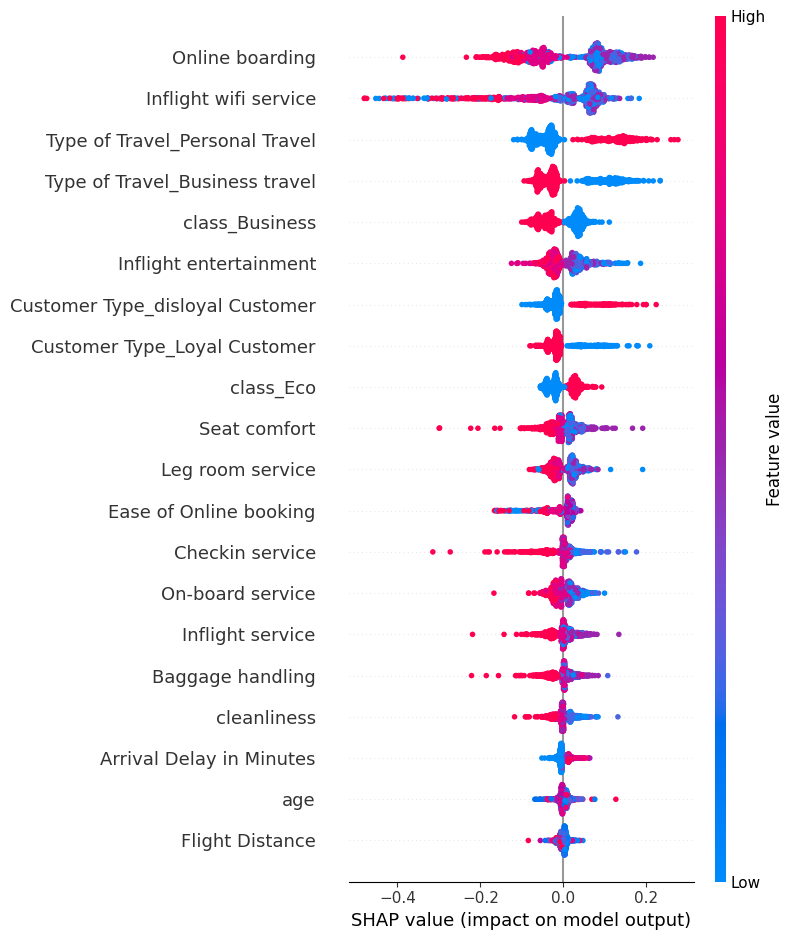

In [163]:
shap.summary_plot(shap_val[0], rand_samples, plot_type='dot', show = False)#, plot_type='dot', show = False)

<font color='#FF6600'>Опишите полученый график</font>

Красным цветом отображаются большие значения весов признака \
Синим - маленькие значения. \
По оси Х можно наблюдать, насколько сильно обьекты разбитые по признакам влияет на выход модели. \
Для примера возьмем признак "class_Eco": \
1. Низкие значения данного признака не сильно отрицательно влияют на выходы нашей модели.
2. Высокие значения данного признака не сильно положительно влияют на выходы нашей модели.

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

Можно нарисовать график "force_plot", который обьясняет единичный prediction нашей модели. \
Можно нарисовать график "dependence_plot", который обьясняет, как мы получили вес конкретного признака.

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [194]:
# please type your solution below

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = X_train.columns,
                                                   class_names=#[0, 1])
                                                   ['Unsatisfied','Satisfied'])

In [198]:
exp = explainer.explain_instance(X_val.iloc[25].values, rdf_sig.predict_proba, num_features=len(X_val))
exp.show_in_notebook(show_all=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<font color='#FF6600'>Опишите полученый график</font>

*Данный предикт был сделан на откалиброванном RandomForest по Платту*\
На графике видно, что модель уверенна, что клиенту совсем не понравился сервис потому что:
1. В пользу того, что клиент удволетворен полетом, говорит только то, что пользователь летал по бизнесу. Это в целом дает весь вес положительны признакам.
2. Против того, что пользователь был удволетворен играют почти все оставшиеся признаки: inflight wifi service: 2, online boarding: 2, checkin service: 2  и тд.
**В сумме получилось, что куча негативных признаков сильно перевесила положительные, поэтому и оценка соответствующая: 94% что клиенту не понравилось или он не будет ставить оценку**

<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

In [199]:
with open('RF.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

# *Отзыв:*
Очень интересное домашнее задание! \
Здесь было всё: и sql, и куча разных моделей, графиков и тд. Потрогали много библиотек, о которых я раньше не знал. Супер!\
По сравнению со вторым дз - это просто бомба. \
# *Что можно добавить:*
Можно убрать одну библу с интерпретацией признаков, например лайм (он какой то кривой) и добавить работу с тестовой выборкой, ведь мы так и не сделали предикт нигде, потому что было написано что работает только на валидационной. \
# *Также*
можно было бы потрогать бустинг уже тут, отказавшись от обычных логистических регрессий, сравнивать только рандом форест и бустинг

**Но все равно дз получилась очень интересной, мне понравилось. Потратил на нее часов 20 наверно**